<a href="https://colab.research.google.com/github/JeonginWon/DataAnalysisProject-Household-Loan-Delinquency-Rate-Prediction-Model/blob/main/%EC%B5%9C%EC%A2%85_%EB%AA%A8%EB%8D%B8%EB%A7%81_%EB%8C%80%EA%B5%AC%EB%8C%80%EC%A0%84%EB%B6%80%EC%82%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score,roc_auc_score,roc_curve

In [ ]:
!wget https://noto-website-2.storage.googleapis.com/pkgs/NotoSansCJKkr-hinted.zip
!unzip -o NotoSansCJKkr-hinted.zip
!mv NotoSansCJKkr* /usr/share/fonts/

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

fm.fontManager.addfont(path='/usr/share/fonts/NotoSansCJKkr-Medium.otf')
prop = fm.FontProperties(fname='/usr/share/fonts/NotoSansCJKkr-Medium.otf')
mpl.rcParams['font.family'] = prop.get_name()
mpl.rcParams['font.weight'] = prop.get_weight()

--2023-08-24 03:45:35--  https://noto-website-2.storage.googleapis.com/pkgs/NotoSansCJKkr-hinted.zip
Resolving noto-website-2.storage.googleapis.com (noto-website-2.storage.googleapis.com)... 74.125.196.207, 74.125.31.207, 173.194.215.207, ...
Connecting to noto-website-2.storage.googleapis.com (noto-website-2.storage.googleapis.com)|74.125.196.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 121163981 (116M) [application/zip]
Saving to: ‘NotoSansCJKkr-hinted.zip’

NotoSansCJKkr-hinte 100%[===================>] 115.55M   110MB/s    in 1.0s    

2023-08-24 03:45:36 (110 MB/s) - ‘NotoSansCJKkr-hinted.zip’ saved [121163981/121163981]

Archive:  NotoSansCJKkr-hinted.zip
  inflating: LICENSE_OFL.txt         
  inflating: NotoSansCJKkr-Black.otf  
  inflating: NotoSansCJKkr-Bold.otf  
  inflating: NotoSansCJKkr-DemiLight.otf  
  inflating: NotoSansCJKkr-Light.otf  
  inflating: NotoSansCJKkr-Medium.otf  
  inflating: NotoSansCJKkr-Regular.otf  
  inflating: NotoS

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
local = pd.read_excel("/content/drive/MyDrive/전처리_원정인/찐찐막 (1).xlsx", sheet_name = '지역')
local
#날짜 열 고치기
#날짜 열을 날짜형으로 바꾸기
local = pd.DataFrame(local)
local['날짜']=local['날짜'].astype('string')
local['날짜'] = local['날짜'].str.replace('.','-')
local['날짜'] = pd.to_datetime(local['날짜'])
local
# 시간 정보를 나타내는 컬럼의 이름
time_column = ['날짜']
# 날짜 컬럼을 datetime 형식으로 변환한 다음, 월(day) 부분을 제거
local['날짜'] = pd.to_datetime(local['날짜']).dt.to_period('M').dt.to_timestamp().dt.strftime('%Y-%m')
#대구 데이터
daegu = local[local['지역']== '대구광역시']
daejeon = local[local['지역']== '대전광역시']
busan = local[local['지역']== '부산광역시']

<ipython-input-4-17d9b9edaa26>:7: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  local['날짜'] = local['날짜'].str.replace('.','-')


In [ ]:
'''
#상관계수 분석 (대구 -> 기준금리 3개월 때 유효)(대전-> 기준금리 6개월 때 유효)(부산 -> 12개월 때 유효)

'''

'\n#상관계수 분석 (대구 -> 기준금리 3개월 때 유효)(대전-> 기준금리 6개월 때 유효)(부산 -> 12개월 때 유효)\n\n'

##대구(daegu) - 3개월, 랜덤포레스트

######시차변수 만들기

In [ ]:
#시차 3개월 미루기
daegu['3개월 후 연체율'] = daegu['가계대출 연체율'].shift(-3)
x_data1 = daegu.drop(columns = ['가계대출 연체율', '3개월 후 연체율']).reset_index()
y1_3month = daegu['3개월 후 연체율'].reset_index()

#3개월 후 연체율을 종속변수로 삼을 때 변수설정
X = x_data1.iloc[:-3]#맨 아래 행 3개 제거
y = y1_3month.iloc[:-3]

<ipython-input-5-b05c24a56007>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daegu['3개월 후 연체율'] = daegu['가계대출 연체율'].shift(-3)


In [ ]:
daegu = daegu.drop(columns = ['가계대출 연체율'])
daegu = daegu.dropna()
daegu

,지역,날짜,실업률,고용률,어음부도율,지가변동률,상장회사수,비은행예금취급기관_금액,주택거래량,예금은행 기타 가계대출금,...,예금은행 주택담보 대출금,아파트매매가격지수,소비자물가지수,이혼율,교육비지출전망지수,부동산지수,부동산시장소비심리지수,통화량,기준금리,3개월 후 연체율
325,대구광역시,2019-09,3.6,61.0,0.04,0.359,0,27551.6,3311,7576.9,...,21897.2,104.6,100.179,3.5,103,88.4,73.9,2853964,1.50,0.26
341,대구광역시,2019-01,2.8,61.5,0.27,0.354,0,27684.7,4105,7827.2,...,22106.5,104.8,100.435,-10.5,103,88.5,87.6,2871952,1.25,0.28
357,대구광역시,2019-11,2.8,67.8,0.06,0.387,0,27681.4,4626,7941.9,...,22238.9,105.5,99.735,46.3,106,88.7,81.5,2917439,1.25,0.31
373,대구광역시,2019-12,5.8,59.1,0.05,0.383,0,27893.7,5376,8231.1,...,22240.0,106.2,99.896,-15.9,106,89.0,112.5,2913610,1.25,0.27
389,대구광역시,2020-01,3.6,59.7,0.07,0.353,0,27954.3,4859,8439.5,...,22371.9,106.9,100.100,1.8,104,89.3,129.5,2922453,1.25,0.30
405,대구광역시,2020-02,3.4,59.8,0.05,0.251,0,28069.3,5346,8550.9,...,22426.2,107.7,100.220,0.4,104,89.6,82.8,2977984,1.25,0.31
421,대구광역시,2020-03,3.2,56.4,0.17,0.188,0,28240.4,4380,8627.6,...,22622.5,107.4,99.950,-7.7,93,89.7,123.3,2986839,0.75,0.24
437,대구광역시,2020-04,2.6,56.2,0.06,0.196,0,28561.7,2826,8620.3,...,22878.5,107.7,99.330,-13.1,92,89.5,105.6,3011431,0.75,0.26
453,대구광역시,2020-05,3.6,56.7,0.05,0.217,0,28619.2,3966,8697.1,...,23011.9,108.4,99.320,-6.6,93,89.5,117.4,3065842,0.50,0.28
469,대구광역시,2020-06,4.5,59.1,0.22,0.267,0,29187.7,5646,8822.1,...,23339.1,109.2,99.630,7.0,95,89.7,124.9,3083082,0.50,0.21


In [ ]:
daegu.describe()

,실업률,고용률,어음부도율,지가변동률,상장회사수,비은행예금취급기관_금액,주택거래량,예금은행 기타 가계대출금,월세수급동향,매매수급동향,...,예금은행 주택담보 대출금,아파트매매가격지수,소비자물가지수,이혼율,교육비지출전망지수,부동산지수,부동산시장소비심리지수,통화량,기준금리,3개월 후 연체율
count,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,...,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,4.200000e+01,42.000000,42.000000
mean,3.388095,61.019048,0.167143,0.275333,0.047619,33892.750000,3151.690476,9656.083333,99.082143,100.018095,...,26220.595238,117.404762,103.555833,2.016667,100.857143,94.826190,106.145238,3.376406e+06,1.273810,0.201905
std,1.348025,2.977086,0.240145,0.114956,0.215540,4772.796551,1969.420981,912.988440,16.565026,12.457149,...,2767.289709,10.452306,3.802438,19.332418,4.164727,4.672862,15.923249,3.148542e+05,0.933472,0.057604
min,1.000000,55.900000,0.000000,-0.056000,0.000000,27551.600000,978.000000,7576.900000,67.100000,67.310000,...,21897.200000,101.400000,99.320000,-26.400000,92.000000,88.400000,73.900000,2.853964e+06,0.500000,0.120000
25%,2.500000,59.100000,0.025000,0.252750,0.000000,29521.150000,1399.250000,9026.575000,86.030000,97.837500,...,23409.150000,107.700000,100.230000,-7.625000,97.250000,89.775000,91.350000,3.085933e+06,0.500000,0.152500
50%,3.300000,60.750000,0.080000,0.307000,0.000000,33509.850000,2828.500000,9849.350000,100.940000,99.850000,...,26562.800000,116.750000,102.130000,-1.100000,102.500000,95.500000,108.350000,3.401682e+06,1.000000,0.190000
75%,4.175000,62.400000,0.235000,0.359750,0.000000,38390.500000,4564.500000,10368.850000,108.315000,105.115000,...,28560.675000,126.675000,106.895000,6.675000,104.000000,99.350000,118.525000,3.671048e+06,1.500000,0.257500
max,7.300000,67.900000,1.220000,0.387000,1.000000,40816.400000,8004.000000,10811.200000,131.940000,128.690000,...,30489.200000,132.500000,110.710000,78.900000,107.000000,100.800000,135.100000,3.802203e+06,3.500000,0.310000


In [ ]:
#상관계수 분석
correlations =daegu.corr()['3개월 후 연체율']
sorted_features = correlations.abs().sort_values(ascending=False)
print(sorted_features)

3개월 후 연체율        1.000000
아파트매매가격지수        0.909319
예금은행 기타 가계대출금    0.886168
부동산지수            0.866972
전세수급동향           0.691568
매매수급동향           0.531539
예금은행 주택담보 대출금    0.430246
통화량              0.429375
지가변동률            0.424149
기준금리             0.383552
비은행예금취급기관_금액     0.326180
교육비지출전망지수        0.292653
주택거래량            0.249085
고용률              0.170032
어음부도율            0.152815
부동산시장소비심리지수      0.146585
실업률              0.140073
월세수급동향           0.123955
소비자물가지수          0.113085
상장회사수            0.051449
이혼율              0.040971
Name: 3개월 후 연체율, dtype: float64


<ipython-input-9-1291d6e9b4ac>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlations =daegu.corr()['3개월 후 연체율']


In [ ]:
correlations

실업률              0.140073
고용률             -0.170032
어음부도율           -0.152815
지가변동률           -0.424149
상장회사수            0.051449
비은행예금취급기관_금액    -0.326180
주택거래량            0.249085
예금은행 기타 가계대출금   -0.886168
월세수급동향          -0.123955
매매수급동향          -0.531539
전세수급동향          -0.691568
예금은행 주택담보 대출금   -0.430246
아파트매매가격지수       -0.909319
소비자물가지수         -0.113085
이혼율              0.040971
교육비지출전망지수       -0.292653
부동산지수           -0.866972
부동산시장소비심리지수     -0.146585
통화량             -0.429375
기준금리             0.383552
3개월 후 연체율        1.000000
Name: 3개월 후 연체율, dtype: float64

####회귀분석 준비
-이진화는 일단 스킵

######변수 추출

In [ ]:
'''
x_data1=daegu.drop(columns=['가계대출 연체율','3개월 후 연체율','6개월 후 연체율','12개월 후 연체율']).reset_index()
y1_1 = daegu["가계대출 연체율"].reset_index()
y1_3month = daegu["3개월 후 연체율"].reset_index()
y1_6month = daegu["6개월 후 연체율"].reset_index()
y1_12month = daegu["12개월 후 연체율"].reset_index()
'''

'\nx_data1=daegu.drop(columns=[\'가계대출 연체율\',\'3개월 후 연체율\',\'6개월 후 연체율\',\'12개월 후 연체율\']).reset_index()\ny1_1 = daegu["가계대출 연체율"].reset_index()\ny1_3month = daegu["3개월 후 연체율"].reset_index()\ny1_6month = daegu["6개월 후 연체율"].reset_index()\ny1_12month = daegu["12개월 후 연체율"].reset_index()\n'

In [ ]:
'''
# 데이터 타입을 실수로 변경
x_data1 = x_data1.astype(float)
'''

'\n# 데이터 타입을 실수로 변경\nx_data1 = x_data1.astype(float)\n'

######상황에 맞는 변수 설정

In [ ]:
daegu

,지역,날짜,실업률,고용률,어음부도율,지가변동률,상장회사수,비은행예금취급기관_금액,주택거래량,예금은행 기타 가계대출금,...,예금은행 주택담보 대출금,아파트매매가격지수,소비자물가지수,이혼율,교육비지출전망지수,부동산지수,부동산시장소비심리지수,통화량,기준금리,3개월 후 연체율
325,대구광역시,2019-09,3.6,61.0,0.04,0.359,0,27551.6,3311,7576.9,...,21897.2,104.6,100.179,3.5,103,88.4,73.9,2853964,1.50,0.26
341,대구광역시,2019-01,2.8,61.5,0.27,0.354,0,27684.7,4105,7827.2,...,22106.5,104.8,100.435,-10.5,103,88.5,87.6,2871952,1.25,0.28
357,대구광역시,2019-11,2.8,67.8,0.06,0.387,0,27681.4,4626,7941.9,...,22238.9,105.5,99.735,46.3,106,88.7,81.5,2917439,1.25,0.31
373,대구광역시,2019-12,5.8,59.1,0.05,0.383,0,27893.7,5376,8231.1,...,22240.0,106.2,99.896,-15.9,106,89.0,112.5,2913610,1.25,0.27
389,대구광역시,2020-01,3.6,59.7,0.07,0.353,0,27954.3,4859,8439.5,...,22371.9,106.9,100.100,1.8,104,89.3,129.5,2922453,1.25,0.30
405,대구광역시,2020-02,3.4,59.8,0.05,0.251,0,28069.3,5346,8550.9,...,22426.2,107.7,100.220,0.4,104,89.6,82.8,2977984,1.25,0.31
421,대구광역시,2020-03,3.2,56.4,0.17,0.188,0,28240.4,4380,8627.6,...,22622.5,107.4,99.950,-7.7,93,89.7,123.3,2986839,0.75,0.24
437,대구광역시,2020-04,2.6,56.2,0.06,0.196,0,28561.7,2826,8620.3,...,22878.5,107.7,99.330,-13.1,92,89.5,105.6,3011431,0.75,0.26
453,대구광역시,2020-05,3.6,56.7,0.05,0.217,0,28619.2,3966,8697.1,...,23011.9,108.4,99.320,-6.6,93,89.5,117.4,3065842,0.50,0.28
469,대구광역시,2020-06,4.5,59.1,0.22,0.267,0,29187.7,5646,8822.1,...,23339.1,109.2,99.630,7.0,95,89.7,124.9,3083082,0.50,0.21


In [ ]:
#상수항 추가
daegu = sm.add_constant(daegu,has_constant='add')
daegu

,const,지역,날짜,실업률,고용률,어음부도율,지가변동률,상장회사수,비은행예금취급기관_금액,주택거래량,...,예금은행 주택담보 대출금,아파트매매가격지수,소비자물가지수,이혼율,교육비지출전망지수,부동산지수,부동산시장소비심리지수,통화량,기준금리,3개월 후 연체율
325,1.0,대구광역시,2019-09,3.6,61.0,0.04,0.359,0,27551.6,3311,...,21897.2,104.6,100.179,3.5,103,88.4,73.9,2853964,1.50,0.26
341,1.0,대구광역시,2019-01,2.8,61.5,0.27,0.354,0,27684.7,4105,...,22106.5,104.8,100.435,-10.5,103,88.5,87.6,2871952,1.25,0.28
357,1.0,대구광역시,2019-11,2.8,67.8,0.06,0.387,0,27681.4,4626,...,22238.9,105.5,99.735,46.3,106,88.7,81.5,2917439,1.25,0.31
373,1.0,대구광역시,2019-12,5.8,59.1,0.05,0.383,0,27893.7,5376,...,22240.0,106.2,99.896,-15.9,106,89.0,112.5,2913610,1.25,0.27
389,1.0,대구광역시,2020-01,3.6,59.7,0.07,0.353,0,27954.3,4859,...,22371.9,106.9,100.100,1.8,104,89.3,129.5,2922453,1.25,0.30
405,1.0,대구광역시,2020-02,3.4,59.8,0.05,0.251,0,28069.3,5346,...,22426.2,107.7,100.220,0.4,104,89.6,82.8,2977984,1.25,0.31
421,1.0,대구광역시,2020-03,3.2,56.4,0.17,0.188,0,28240.4,4380,...,22622.5,107.4,99.950,-7.7,93,89.7,123.3,2986839,0.75,0.24
437,1.0,대구광역시,2020-04,2.6,56.2,0.06,0.196,0,28561.7,2826,...,22878.5,107.7,99.330,-13.1,92,89.5,105.6,3011431,0.75,0.26
453,1.0,대구광역시,2020-05,3.6,56.7,0.05,0.217,0,28619.2,3966,...,23011.9,108.4,99.320,-6.6,93,89.5,117.4,3065842,0.50,0.28
469,1.0,대구광역시,2020-06,4.5,59.1,0.22,0.267,0,29187.7,5646,...,23339.1,109.2,99.630,7.0,95,89.7,124.9,3083082,0.50,0.21


####랜덤 포레스트 회귀로 변수 추출
- feature importances


In [ ]:
daegu.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42 entries, 325 to 981
Data columns (total 24 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   const          42 non-null     float64
 1   지역             42 non-null     object 
 2   날짜             42 non-null     object 
 3   실업률            42 non-null     float64
 4   고용률            42 non-null     float64
 5   어음부도율          42 non-null     float64
 6   지가변동률          42 non-null     float64
 7   상장회사수          42 non-null     int64  
 8   비은행예금취급기관_금액   42 non-null     float64
 9   주택거래량          42 non-null     int64  
 10  예금은행 기타 가계대출금  42 non-null     float64
 11  월세수급동향         42 non-null     float64
 12  매매수급동향         42 non-null     float64
 13  전세수급동향         42 non-null     float64
 14  예금은행 주택담보 대출금  42 non-null     float64
 15  아파트매매가격지수      42 non-null     float64
 16  소비자물가지수        42 non-null     float64
 17  이혼율            42 non-null     float64
 18  교육비지출전망지수

Feature ranking:
아파트매매가격지수: 0.6740521537324199
예금은행 기타 가계대출금: 0.12299607547908055
지가변동률: 0.047047163003029434
전세수급동향: 0.03822724868039522
부동산지수: 0.03356032000987256
이혼율: 0.01621084427080653
월세수급동향: 0.010263352680945591
부동산시장소비심리지수: 0.008383264923288487
비은행예금취급기관_금액: 0.007724446236188737
고용률 : 0.007312293827041069
교육비지출전망지수: 0.006941997960354028
실업률: 0.005303688958364012
매매수급동향: 0.004702157612517652
주택거래량: 0.003992245379968887
어음부도율: 0.0035669068383609435
통화량: 0.0028388978094697095
예금은행 주택담보 대출금: 0.0027501203971470036
소비자물가지수: 0.0025776926002436806
기준금리: 0.001265325532980648
상장회사수: 0.00028380406752559874


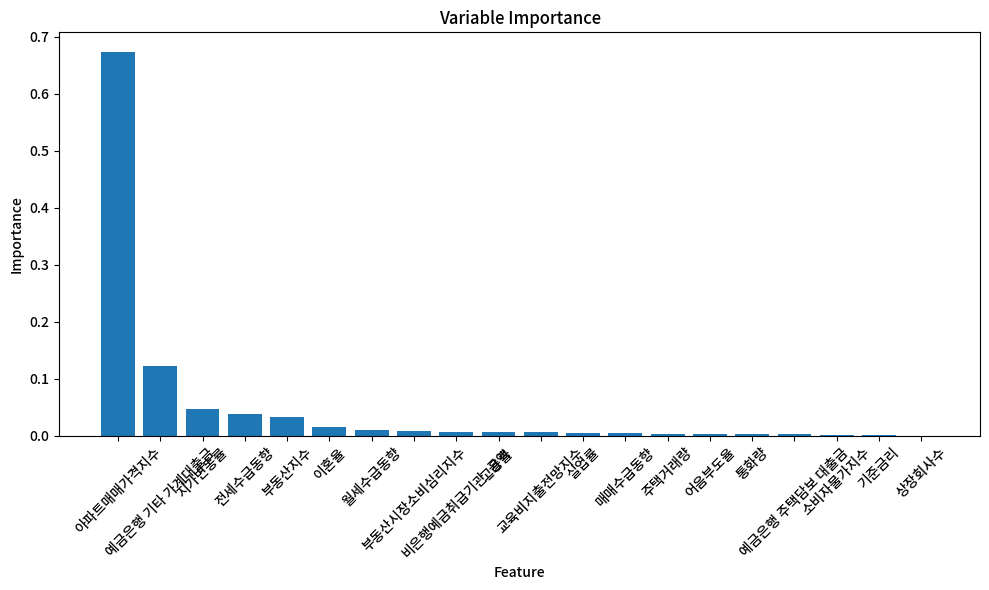

In [ ]:
#랜덤포레스트로 변수 추출

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# 데이터 준비 (X는 독립 변수, y는 종속 변수)
X = daegu[['실업률', '고용률 ', '어음부도율', '지가변동률', '상장회사수', '비은행예금취급기관_금액', '주택거래량',
       '예금은행 기타 가계대출금', '월세수급동향', '매매수급동향', '전세수급동향', '예금은행 주택담보 대출금',
       '아파트매매가격지수', '소비자물가지수', '이혼율', '교육비지출전망지수', '부동산지수', '부동산시장소비심리지수','기준금리','통화량']] # 독립 변수 데이터
y = daegu['3개월 후 연체율']  # 종속 변수 데이터

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

rf_model = RandomForestRegressor(random_state=0)
rf_model.fit(X_train, y_train)

importances = rf_model.feature_importances_

feature_names = X.columns

# 변수 중요도를 내림차순으로 정렬하여 출력 및 시각화
indices = np.argsort(importances)[::-1]

print("Feature ranking:")
for i in indices:
    print(f"{feature_names[i]}: {importances[i]}")

# 변수 중요도 시각화
plt.figure(figsize=(10, 6))
plt.bar(range(len(importances)), importances[indices], align='center')
plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=45)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Variable Importance')
plt.tight_layout()
plt.show()

###대구 랜포로 추출한 변수 7개
X변수 7개 추출 : 아파트매매가격지수, 예금은행 기타 가계대출금, 지가변동률, 전세수급동향, 부동산지수, 이혼율, 월세수급동향

In [ ]:
daegu.columns

Index(['const', '지역', '날짜', '실업률', '고용률 ', '어음부도율', '지가변동률', '상장회사수',
       '비은행예금취급기관_금액', '주택거래량', '예금은행 기타 가계대출금', '월세수급동향', '매매수급동향', '전세수급동향',
       '예금은행 주택담보 대출금', '아파트매매가격지수', '소비자물가지수', '이혼율', '교육비지출전망지수', '부동산지수',
       '부동산시장소비심리지수', '통화량', '기준금리', '3개월 후 연체율'],
      dtype='object')

#### 선형회귀분석(회귀계수 추출)



#####정규화

In [ ]:
X1=daegu[['아파트매매가격지수','예금은행 기타 가계대출금','지가변동률','전세수급동향','부동산지수','이혼율','월세수급동향']]
y= daegu[['3개월 후 연체율']]
#z-score 정규화
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Z-score 정규화
scaler = StandardScaler()
z_score_normalized = scaler.fit_transform(X1)

# 정규화된 데이터프레임 생성
normalized_data = pd.DataFrame(z_score_normalized, columns=X1.columns)
X1 = normalized_data

#상수항 추가
X1 = sm.add_constant(X1,has_constant='add')
X1


,const,아파트매매가격지수,예금은행 기타 가계대출금,지가변동률,전세수급동향,부동산지수,이혼율,월세수급동향
0,1.0,-1.239916,-2.304943,0.736635,-0.456841,-1.391885,0.077658,0.097018
1,1.0,-1.220549,-2.027465,0.692613,-0.128523,-1.370225,-0.655293,0.302925
2,1.0,-1.152766,-1.900311,0.983158,-0.170856,-1.326906,2.318392,0.302925
3,1.0,-1.084984,-1.579709,0.947940,-0.942262,-1.261928,-0.938002,0.172782
4,1.0,-1.017201,-1.348681,0.683808,-0.752233,-1.196949,-0.011343,0.466672
5,1.0,-0.939735,-1.225185,-0.214240,-0.678855,-1.131970,-0.084638,0.493556
6,1.0,-0.968785,-1.140157,-0.768918,-0.509522,-1.110311,-0.508702,0.130012
7,1.0,-0.939735,-1.148250,-0.698482,-0.889581,-1.153630,-0.791412,-0.354510
8,1.0,-0.871952,-1.063111,-0.513590,-0.879232,-1.153630,-0.451114,-0.158991
9,1.0,-0.794487,-0.924538,-0.073370,-0.509522,-1.110311,0.260895,0.318811


#####다중공선성 검사
(시차마다 다르므로 주의)

In [ ]:
'''
#다중공선성

from statsmodels.stats.outliers_influence import variance_inflation_factor
#영향을 주는 이상치 모듈에서 분산팽창요인 가져오기

vif=pd.DataFrame() #vif라는 빈 데이터프레임 형성
vif["VIF Factor"]= [variance_inflation_factor(X1.values,i)for i in range(X1.shape[1])]
#vif에 "VIF Factor"라는 변수에 x_data의 값들의 분산팽창요인을 넣고 범위는 (x_data.shape[1])

vif["features"] = X1.columns #"features"라는 변수에 x_data의 열변수들 입력
vif
'''

'\n#다중공선성\n\nfrom statsmodels.stats.outliers_influence import variance_inflation_factor\n#영향을 주는 이상치 모듈에서 분산팽창요인 가져오기\n\nvif=pd.DataFrame() #vif라는 빈 데이터프레임 형성\nvif["VIF Factor"]= [variance_inflation_factor(X1.values,i)for i in range(X1.shape[1])]\n#vif에 "VIF Factor"라는 변수에 x_data의 값들의 분산팽창요인을 넣고 범위는 (x_data.shape[1])\n\nvif["features"] = X1.columns #"features"라는 변수에 x_data의 열변수들 입력\nvif\n'

In [ ]:
'''
#vif가 가장 높은 변수 제거해보기(하나하나씩 차근차근)

vif=pd.DataFrame()

X2=X1.drop('아파트매매가격지수', axis=1)

vif["VIF Factor"]= [variance_inflation_factor(X2.values,i)for i in range(X2.shape[1])]

vif["features"] = X2.columns
vif
'''

'\n#vif가 가장 높은 변수 제거해보기(하나하나씩 차근차근)\n\nvif=pd.DataFrame()\n\nX2=X1.drop(\'아파트매매가격지수\', axis=1)\n\nvif["VIF Factor"]= [variance_inflation_factor(X2.values,i)for i in range(X2.shape[1])]\n\nvif["features"] = X2.columns\nvif\n'

In [ ]:
'''
#vif가 가장 높은 변수 제거해보기(하나하나씩 차근차근)

vif=pd.DataFrame()

X3=X2.drop('부동산지수', axis=1)

vif["VIF Factor"]= [variance_inflation_factor(X3.values,i)for i in range(X3.shape[1])]

vif["features"] = X3.columns
vif
'''

'\n#vif가 가장 높은 변수 제거해보기(하나하나씩 차근차근)\n\nvif=pd.DataFrame()\n\nX3=X2.drop(\'부동산지수\', axis=1)\n\nvif["VIF Factor"]= [variance_inflation_factor(X3.values,i)for i in range(X3.shape[1])]\n\nvif["features"] = X3.columns\nvif\n'

###최종모델선정

#####선형회귀 모델 - 다시

In [ ]:
# 회귀 분석을 위한 모델 생성
X = daegu[['아파트매매가격지수','예금은행 기타 가계대출금','지가변동률','전세수급동향','부동산지수','이혼율','월세수급동향']]
X = sm.add_constant(X)  # 상수항 추가
y = daegu['3개월 후 연체율']

# 회귀 모델 생성
model = sm.OLS(y, X).fit()

# 회귀 결과 출력
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              3개월 후 연체율   R-squared:                       0.877
Model:                            OLS   Adj. R-squared:                  0.852
Method:                 Least Squares   F-statistic:                     34.62
Date:                Thu, 24 Aug 2023   Prob (F-statistic):           1.14e-13
Time:                        03:48:06   Log-Likelihood:                 104.78
No. Observations:                  42   AIC:                            -193.6
Df Residuals:                      34   BIC:                            -179.7
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             1.1093      0.273      4.059

Mean Squared Error (MSE): 0.0006202975293209637
Root Mean Squared Error (RMSE): 0.024905773011913598
Mean Absolute Error (MAE): 0.020649999263184043
R-squared (R2): 0.7808731554029205


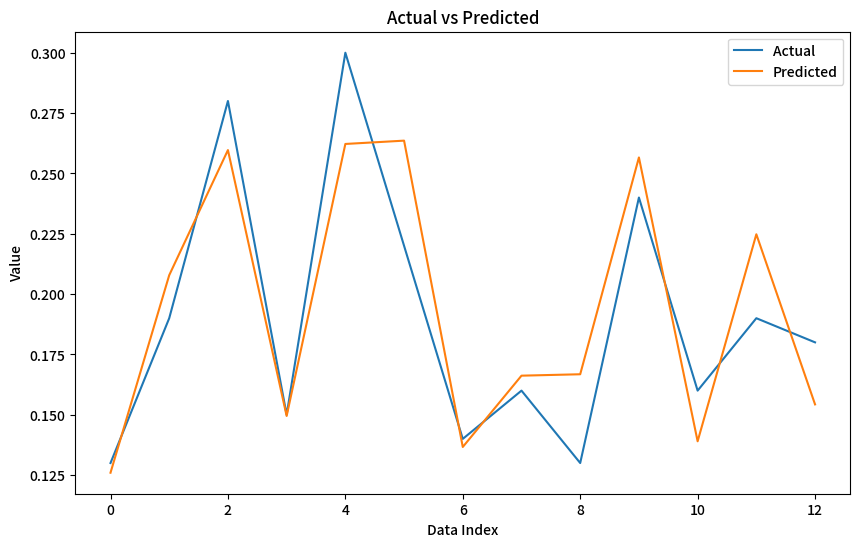

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# 훈련 세트와 테스트 세트로 데이터 나누기
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Linear Regression 모델 생성 및 훈련
model = LinearRegression()
model.fit(X_train, y_train)

# 테스트 데이터에 대한 예측 수행
y_pred = model.predict(X_test)

# Mean Squared Error (MSE) 계산
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error (MSE):", mse)

# Root Mean Squared Error (RMSE) 계산
rmse = mean_squared_error(y_test, y_pred, squared=False)
print("Root Mean Squared Error (RMSE):", rmse)

# Mean Absolute Error (MAE) 계산
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error (MAE):", mae)

# R-squared (Coefficient of Determination) 계산
r2 = r2_score(y_test, y_pred)
print("R-squared (R2):", r2)

# 예측 결과 비교를 위한 그래프
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title("Actual vs Predicted")
plt.xlabel("Data Index")
plt.ylabel("Value")
plt.legend()
plt.show()


#####Ridge 회귀



In [ ]:
import numpy as np
from sklearn.datasets import make_regression
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Ridge 회귀 모델 생성
alpha = 1.0  # alpha 값은 규제의 강도를 조절하는 하이퍼파라미터
ridge_model = Ridge(alpha=alpha)

# 모델 훈련
ridge_model.fit(X_train, y_train)

# 테스트 데이터 예측
y_pred = ridge_model.predict(X_test)

# 모델 평가
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# R-squared (R²)
r2 = r2_score(y_test, y_pred)
print(f"R-squared (R²): {r2}")

Mean Squared Error: 0.0006162909566431833
R-squared (R²): 0.7822885207510494


#####RandomForest


-est Hyperparameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}

-Mean Squared Error (MSE): 0.0018685907692307638

-RMSE: 0.043227199414613525

-Mean Absolute Error (MAE): 0.03258461538461535

-R-squared (R²): 0.9170584020591482

-과적합 아님

Rank 1: Feature 비은행예금취급기관_금액, Importance: 0.31903466722045276

Rank 2: Feature 예금은행 주택담보 대출금, Importance: 0.2029605128854524

Rank 3: Feature 지가변동률, Importance: 0.18732498059658947

Rank 4: Feature 주택거래량, Importance: 0.1459103362383612

Rank 5: Feature 예금은행 기타 가계대출금, Importance: 0.14476950305914424

Rank 6: Feature const, Importance: 0.0


Best Hyperparameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50}
Mean Squared Error (MSE): 0.0005283733577611103
RMSE: 0.022986373305963478
Mean Absolute Error (MAE): 0.01943042735042736
R-squared (R²): 0.8133463681822165
Train CV MSE: 0.0006470207265868393
Test CV MSE: 0.0009195004756916106
과적합 아닙니다
Rank 1: Feature 예금은행 기타 가계대출금, Importance: 0.3288576751033633
Rank 2: Feature 아파트매매가격지수, Importance: 0.24653190215880447
Rank 3: Feature 부동산지수, Importance: 0.2131871131514485
Rank 4: Feature 전세수급동향, Importance: 0.09194169900860169
Rank 5: Feature 지가변동률, Importance: 0.05924230172760242
Rank 6: Feature 월세수급동향, Importance: 0.03077616503033487
Rank 7: Feature 이혼율, Importance: 0.029463143819844752
Rank 8: Feature const, Importance: 0.0


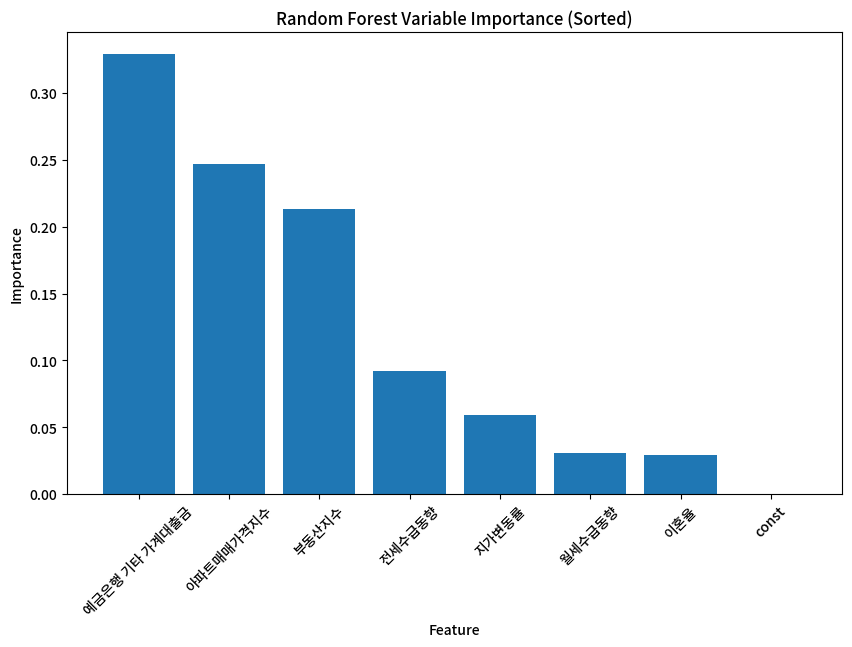

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold

# 데이터를 훈련 세트와 테스트 세트로 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 랜덤 포레스트 회귀 모델 생성
rf_regressor = RandomForestRegressor(random_state=42)


# 그리드 서치에 사용할 하이퍼파라미터 후보값 정의
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20,30],
    'min_samples_split': [2, 4, 8],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# 그리드 서치를 사용하여 최적의 하이퍼파라미터 탐색
grid_search = GridSearchCV(rf_regressor, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

# 최적의 하이퍼파라미터 출력
best_params = grid_search.best_params_
print(f"Best Hyperparameters: {best_params}")

# 최적의 모델로 테스트 세트 예측
best_rf_regressor = grid_search.best_estimator_
y_pred = best_rf_regressor.predict(X_test)


# 평균 제곱 오차 (Mean Squared Error, MSE)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error (MSE): {mse}")

# RMSE 계산
rmse = np.sqrt(mse)
print("RMSE:", rmse)

import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 평균 절대 오차 (Mean Absolute Error, MAE)
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error (MAE): {mae}")

# R-squared (R²)
r2 = r2_score(y_test, y_pred)
print(f"R-squared (R²): {r2}")

# 교차 검증으로 훈련 세트의 평균 제곱 오차 (MSE) 계산
train_cv_scores = cross_val_score(best_rf_regressor, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
train_mse = -np.mean(train_cv_scores)  # 부호 변경하여 양수로 변환
print("Train CV MSE:", train_mse)

# 교차 검증으로 테스트 세트의 평균 제곱 오차 (MSE) 계산
test_cv_scores = cross_val_score(best_rf_regressor, X_test, y_test, cv=5, scoring='neg_mean_squared_error')
test_mse = -np.mean(test_cv_scores)  # 부호 변경하여 양수로 변환
print("Test CV MSE:", test_mse)


# 과적합 여부 확인
if train_mse < test_mse:
    print("과적합 아닙니다")
else:
    print("과적합입니다")

#모델의 변수 중요도
importances = best_rf_regressor.feature_importances_

# 변수 중요도 내림차순으로 정렬한 인덱스
sorted_indices = np.argsort(importances)[::-1]

# 정렬된 변수 중요도와 변수명 출력
for i, idx in enumerate(sorted_indices):
    print(f"Rank {i + 1}: Feature {X_train.columns[idx]}, Importance: {importances[idx]}")

# 변수 중요도 내림차순으로 정렬 및 시각화
sorted_indices = np.argsort(importances)[::-1]  # 중요도 내림차순으로 정렬된 인덱스
sorted_feature_names = [X_train.columns[i] for i in sorted_indices]  # 정렬된 특성 이름
sorted_importances = importances[sorted_indices]  # 정렬된 중요도

plt.figure(figsize=(10, 6))
plt.bar(sorted_feature_names, sorted_importances)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Random Forest Variable Importance (Sorted)')
plt.xticks(rotation=45)
plt.show()

In [ ]:
print(y_pred,y_test)

[0.13844111 0.21351667 0.26557905 0.1508173  0.27835952 0.25769667
 0.15265778 0.16515667 0.16324667 0.2660119  0.1460673  0.23282667
 0.16777   ] 725    0.13
533    0.19
453    0.28
741    0.15
389    0.30
949    0.22
629    0.14
789    0.16
805    0.13
421    0.24
757    0.16
517    0.19
597    0.18
Name: 3개월 후 연체율, dtype: float64


#####XGBoost

-Best Hyperparameters: {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}

-Mean Squared Error (MSE): 0.0039039075416568213

-RMSE: 0.06248125752301102

-Mean Absolute Error (MAE): 0.040191912284264206

-R-squared (R²): 0.8267162960182795

과적합 아닙니다

Rank 1: Feature 비은행예금취급기관_금액, Importance: 0.499472439289093

Rank 2: Feature 지가변동률, Importance: 0.24382704496383667

Rank 3: Feature 주택거래량, Importance: 0.19857999682426453

Rank 4: Feature 예금은행 기타 가계대출금, Importance: 0.055112604051828384

Rank 5: Feature 예금은행 주택담보 대출금, Importance: 0.0030079020652920008

Rank 6: Feature const, Importance: 0.0

Best Hyperparameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 3, 'n_estimators': 50, 'subsample': 0.8}
Mean Squared Error (MSE): 0.0004462144813416855
RMSE: 0.02112378946452756
Mean Absolute Error (MAE): 0.016884492773276107
R-squared (R²): 0.8423698843086437
Train CV MSE: 0.0007336925114481035
Test CV MSE: 0.0010654035584489498
과적합 아닙니다
Rank 1: Feature 아파트매매가격지수, Importance: 0.3964877128601074
Rank 2: Feature 부동산지수, Importance: 0.2943941354751587
Rank 3: Feature 예금은행 기타 가계대출금, Importance: 0.11524933576583862
Rank 4: Feature 전세수급동향, Importance: 0.06733434647321701
Rank 5: Feature 이혼율, Importance: 0.04974919557571411
Rank 6: Feature 월세수급동향, Importance: 0.03857957571744919
Rank 7: Feature 지가변동률, Importance: 0.03820565715432167
Rank 8: Feature const, Importance: 0.0


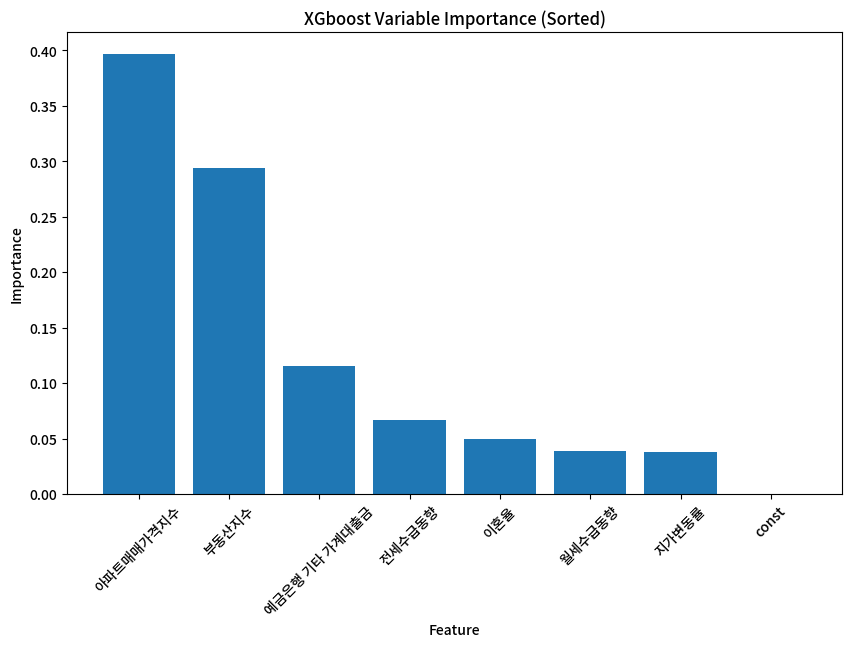

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold

# 데이터를 훈련 세트와 테스트 세트로 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# xgboost 회귀 모델 생성
xgb_regressor = XGBRegressor(n_estimators=1000)


# 그리드 서치에 사용할 하이퍼파라미터 후보값 정의
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_child_weight': [1, 2, 3],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

# 그리드 서치를 사용하여 최적의 하이퍼파라미터 탐색
grid_search = GridSearchCV(xgb_regressor, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

# 최적의 하이퍼파라미터 출력
best_params = grid_search.best_params_
print(f"Best Hyperparameters: {best_params}")

# 최적의 모델로 테스트 세트 예측
best_xgb_regressor = grid_search.best_estimator_
y_pred = best_xgb_regressor.predict(X_test)


# 평균 제곱 오차 (Mean Squared Error, MSE)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error (MSE): {mse}")

# RMSE 계산
rmse = np.sqrt(mse)
print("RMSE:", rmse)

import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 평균 절대 오차 (Mean Absolute Error, MAE)
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error (MAE): {mae}")

# R-squared (R²)
r2 = r2_score(y_test, y_pred)
print(f"R-squared (R²): {r2}")

# 교차 검증으로 훈련 세트의 평균 제곱 오차 (MSE) 계산
train_cv_scores = cross_val_score(best_xgb_regressor, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
train_mse = -np.mean(train_cv_scores)  # 부호 변경하여 양수로 변환
print("Train CV MSE:", train_mse)

# 교차 검증으로 테스트 세트의 평균 제곱 오차 (MSE) 계산
test_cv_scores = cross_val_score(best_xgb_regressor, X_test, y_test, cv=5, scoring='neg_mean_squared_error')
test_mse = -np.mean(test_cv_scores)  # 부호 변경하여 양수로 변환
print("Test CV MSE:", test_mse)


# 과적합 여부 확인
if train_mse < test_mse:
    print("과적합 아닙니다")
else:
    print("과적합입니다")

#모델의 변수 중요도
importances = best_xgb_regressor.feature_importances_

# 변수 중요도 내림차순으로 정렬한 인덱스
sorted_indices = np.argsort(importances)[::-1]

# 정렬된 변수 중요도와 변수명 출력
for i, idx in enumerate(sorted_indices):
    print(f"Rank {i + 1}: Feature {X_train.columns[idx]}, Importance: {importances[idx]}")

# 변수 중요도 내림차순으로 정렬 및 시각화
sorted_indices = np.argsort(importances)[::-1]  # 중요도 내림차순으로 정렬된 인덱스
sorted_feature_names = [X_train.columns[i] for i in sorted_indices]  # 정렬된 특성 이름
sorted_importances = importances[sorted_indices]  # 정렬된 중요도

plt.figure(figsize=(10, 6))
plt.bar(sorted_feature_names, sorted_importances)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('XGboost Variable Importance (Sorted)')
plt.xticks(rotation=45)
plt.show()

######방법론들의 성능 지표 : 교차 검증의 평균 RMSE

-Model: RandomForestRegressor

Average RMSE: 0.14683660953909336

-Model: DecisionTreeRegressor

Average RMSE: 0.15222884629738515

-Model: GradientBoostingRegressor

Average RMSE: 0.15197669075638737

-Model: XGBRegressor

Average RMSE: 0.16160334533409326


In [ ]:
# def get_model_cv_prediction(model,X,y):
#   neg_mse_scores=cross_val_score(model,X,y,scoring='neg_mean_squared_error',cv=5)
#   rmse_scores = np.sqrt(-1*neg_mse_scores)
#   avg_rmse = np.mean(rmse_scores)
#   print(f"Model: {model.__class__.__name__}")
#   print(f"Average RMSE: {avg_rmse}")

# # 모델들의 리스트 생성
# models = [best_rf_regressor, best_dt_regressor, best_gb_regressor, best_xgb_regressor]

# # 함수 호출
# get_model_cv_prediction(best_xgb_regressor, X, y)

##대전(daejeon) -6개월

###시차변수 만들기

In [ ]:
#시차 6개월 미루기
daejeon['6개월 후 연체율'] = daejeon['가계대출 연체율'].shift(-6)
x_data1 = daejeon.drop(columns = ['가계대출 연체율', '6개월 후 연체율']).reset_index()
y1_6month = daejeon['6개월 후 연체율'].reset_index()

#6개월 후 연체율을 종속변수로 삼을 때 변수설정
X = x_data1.iloc[:-6]#맨 아래 행 6개 제거
y = y1_6month.iloc[:-6]

<ipython-input-29-d6e5f4438141>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daejeon['6개월 후 연체율'] = daejeon['가계대출 연체율'].shift(-6)


In [ ]:
daejeon = daejeon.drop(columns = ['가계대출 연체율'])
daejeon = daejeon.dropna()
daejeon

KeyError: ignored

In [ ]:
#상관계수 분석
correlations =daejeon.corr()['6개월 후 연체율']
sorted_features = correlations.abs().sort_values(ascending=False)
print(sorted_features)

6개월 후 연체율        1.000000
예금은행 기타 가계대출금    0.868108
아파트매매가격지수        0.778026
예금은행 주택담보 대출금    0.756902
부동산지수            0.657945
기준금리             0.538906
월세수급동향           0.481333
전세수급동향           0.462445
통화량              0.456240
비은행예금취급기관_금액     0.271172
부동산시장소비심리지수      0.255121
주택거래량            0.227980
교육비지출전망지수        0.218618
이혼율              0.167965
지가변동률            0.151673
소비자물가지수          0.144970
어음부도율            0.143379
고용률              0.089134
매매수급동향           0.032231
실업률              0.016592
상장회사수            0.010362
Name: 6개월 후 연체율, dtype: float64


<ipython-input-32-98be7191af17>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlations =daejeon.corr()['6개월 후 연체율']


In [ ]:
correlations

실업률             -0.016592
고용률              0.089134
어음부도율           -0.143379
지가변동률           -0.151673
상장회사수           -0.010362
비은행예금취급기관_금액    -0.271172
주택거래량            0.227980
예금은행 기타 가계대출금   -0.868108
월세수급동향          -0.481333
매매수급동향          -0.032231
전세수급동향          -0.462445
예금은행 주택담보 대출금   -0.756902
아파트매매가격지수       -0.778026
소비자물가지수         -0.144970
이혼율              0.167965
교육비지출전망지수       -0.218618
부동산지수           -0.657945
부동산시장소비심리지수     -0.255121
통화량             -0.456240
기준금리             0.538906
6개월 후 연체율        1.000000
Name: 6개월 후 연체율, dtype: float64

###회귀분석 준비

######변수 추출

###### 상황에 맞는 변수 설정

In [ ]:
#상수항 추가
daejeon = sm.add_constant(daejeon,has_constant='add')
daejeon

,const,지역,날짜,실업률,고용률,어음부도율,지가변동률,상장회사수,비은행예금취급기관_금액,주택거래량,...,예금은행 주택담보 대출금,아파트매매가격지수,소비자물가지수,이혼율,교육비지출전망지수,부동산지수,부동산시장소비심리지수,통화량,기준금리,6개월 후 연체율
278,1.0,대전광역시,2019-06,4.5,61.1,0.29,0.360,0,15069.9,2478,...,10848.4,103.6,99.656,42.2,98,77.6,86.9,2813933,1.75,0.31
294,1.0,대전광역시,2019-07,3.4,63.0,0.18,0.382,0,15176.4,3071,...,10933.6,104.6,99.322,-3.2,98,77.9,113.2,2807362,1.50,0.34
310,1.0,대전광역시,2019-08,3.7,60.5,0.01,0.383,0,15265.8,3087,...,11036.1,106.2,99.532,12.2,95,78.5,90.7,2848885,1.50,0.35
326,1.0,대전광역시,2019-09,2.8,62.3,0.04,0.394,1,15314.6,3136,...,11237.4,107.7,99.800,-7.7,99,79.2,77.0,2853964,1.50,0.27
342,1.0,대전광역시,2019-01,2.7,61.4,0.27,0.466,0,15379.8,3911,...,11357.2,109.1,100.058,6.3,97,80.2,82.9,2871952,1.25,0.31
358,1.0,대전광역시,2019-11,2.8,67.9,0.14,0.437,0,15554.9,4184,...,11497.5,111.7,99.503,-0.4,101,81.1,81.7,2917439,1.25,0.32
374,1.0,대전광역시,2019-12,4.8,59.2,0.03,0.436,3,15611.2,4982,...,11611.5,114.3,99.781,-4.4,102,82.1,131.9,2913610,1.25,0.23
390,1.0,대전광역시,2020-01,4.2,59.5,0.06,0.469,0,15641.5,3858,...,11649.8,116.2,100.140,13.5,103,83.1,118.2,2922453,1.25,0.23
406,1.0,대전광역시,2020-02,2.9,60.2,0.30,0.483,0,15702.4,4099,...,11785.8,119.2,100.200,0.0,101,84.0,93.7,2977984,1.25,0.26
422,1.0,대전광역시,2020-03,4.0,55.5,0.11,0.371,0,15665.0,3821,...,11753.1,120.8,99.910,5.1,95,85.1,126.2,2986839,0.75,0.22


###랜덤 포레스트 회귀로 변수 추출

In [ ]:
daejeon.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42 entries, 278 to 934
Data columns (total 24 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   const          42 non-null     float64
 1   지역             42 non-null     object 
 2   날짜             42 non-null     object 
 3   실업률            42 non-null     float64
 4   고용률            42 non-null     float64
 5   어음부도율          42 non-null     float64
 6   지가변동률          42 non-null     float64
 7   상장회사수          42 non-null     int64  
 8   비은행예금취급기관_금액   42 non-null     float64
 9   주택거래량          42 non-null     int64  
 10  예금은행 기타 가계대출금  42 non-null     float64
 11  월세수급동향         42 non-null     float64
 12  매매수급동향         42 non-null     float64
 13  전세수급동향         42 non-null     float64
 14  예금은행 주택담보 대출금  42 non-null     float64
 15  아파트매매가격지수      42 non-null     float64
 16  소비자물가지수        42 non-null     float64
 17  이혼율            42 non-null     float64
 18  교육비지출전망지수

Feature ranking:
예금은행 기타 가계대출금: 0.42559346700153106
기준금리: 0.08525204840640793
소비자물가지수: 0.08519347059657777
예금은행 주택담보 대출금: 0.059254626133334584
아파트매매가격지수: 0.05691440053479141
부동산지수: 0.053265793600055705
비은행예금취급기관_금액: 0.04452529447098594
통화량: 0.030274395514556147
매매수급동향: 0.0254711015171154
지가변동률: 0.01982018694800982
고용률 : 0.016713066377252037
이혼율: 0.01569881562560115
월세수급동향: 0.014327235203413042
전세수급동향: 0.014073592028400332
부동산시장소비심리지수: 0.012858234586948434
교육비지출전망지수: 0.01082420467656323
어음부도율: 0.009721782302508766
주택거래량: 0.009418367171933718
실업률: 0.007461418487153033
상장회사수: 0.003338498816860459


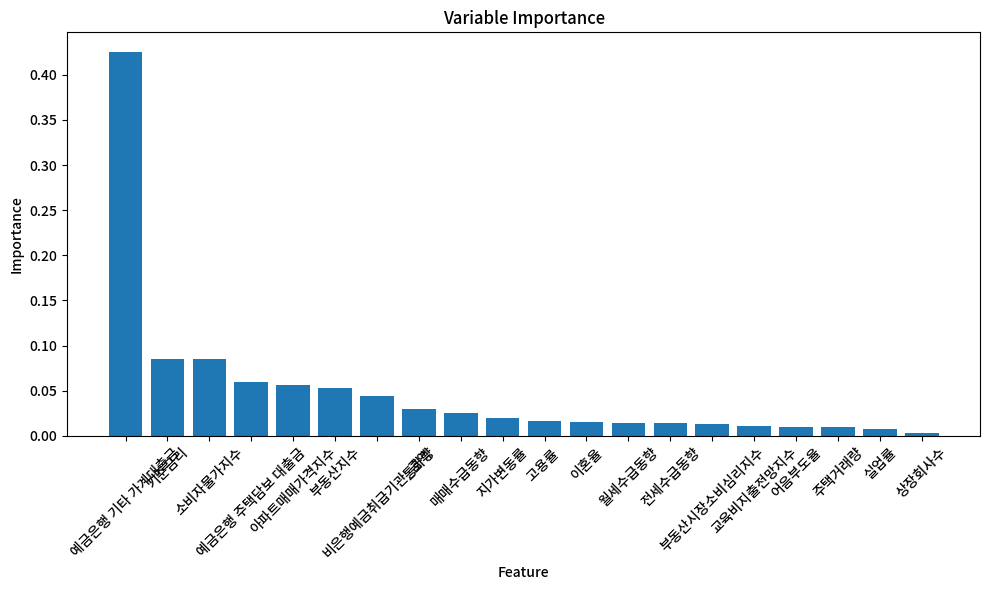

In [ ]:
#랜덤포레스트로 변수 추출

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# 데이터 준비 (X는 독립 변수, y는 종속 변수)
X = daejeon[['실업률', '고용률 ', '어음부도율', '지가변동률', '상장회사수', '비은행예금취급기관_금액', '주택거래량',
       '예금은행 기타 가계대출금', '월세수급동향', '매매수급동향', '전세수급동향', '예금은행 주택담보 대출금',
       '아파트매매가격지수', '소비자물가지수', '이혼율', '교육비지출전망지수', '부동산지수', '부동산시장소비심리지수','기준금리','통화량']] # 독립 변수 데이터
y = daejeon['6개월 후 연체율']  # 종속 변수 데이터

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

rf_model = RandomForestRegressor(random_state=0)
rf_model.fit(X_train, y_train)

importances = rf_model.feature_importances_

feature_names = X.columns

# 변수 중요도를 내림차순으로 정렬하여 출력 및 시각화
indices = np.argsort(importances)[::-1]

print("Feature ranking:")
for i in indices:
    print(f"{feature_names[i]}: {importances[i]}")

# 변수 중요도 시각화
plt.figure(figsize=(10, 6))
plt.bar(range(len(importances)), importances[indices], align='center')
plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=45)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Variable Importance')
plt.tight_layout()
plt.show()

### 대전: 랜포로 추출한 변수 7개
예금은행 기타 가계대출금, 기준금리, 소비자물가지수, 예금은행 주택담보 대출금, 아파트매매가격지수, 부동산지수, 비은행예금취급기관_금액

###선형회귀분석

#####정규화

In [ ]:
X1=daejeon[['기준금리','예금은행 기타 가계대출금','소비자물가지수','예금은행 주택담보 대출금','아파트매매가격지수','부동산지수','비은행예금취급기관_금액']]
y= daejeon[['6개월 후 연체율']]
#z-score 정규화
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Z-score 정규화
scaler = StandardScaler()
z_score_normalized = scaler.fit_transform(X1)

# 정규화된 데이터프레임 생성
normalized_data = pd.DataFrame(z_score_normalized, columns=X1.columns)
X1 = normalized_data

#상수항 추가
X1 = sm.add_constant(X1,has_constant='add')
X1

,const,기준금리,예금은행 기타 가계대출금,소비자물가지수,예금은행 주택담보 대출금,아파트매매가격지수,부동산지수,비은행예금취급기관_금액
0,1.0,0.848235,-1.729324,-0.922009,-2.133186,-1.859121,-1.800252,-1.231893
1,1.0,0.498962,-1.645344,-1.026941,-2.029452,-1.806259,-1.767425,-1.190149
2,1.0,0.498962,-1.519257,-0.960965,-1.904654,-1.721679,-1.701772,-1.155109
3,1.0,0.498962,-1.474359,-0.876768,-1.659562,-1.642385,-1.625177,-1.135981
4,1.0,0.149688,-1.339433,-0.795713,-1.513701,-1.568378,-1.515755,-1.110426
5,1.0,0.149688,-1.179847,-0.970076,-1.342880,-1.430935,-1.417275,-1.041794
6,1.0,0.149688,-1.068417,-0.882738,-1.204080,-1.293493,-1.307853,-1.019727
7,1.0,0.149688,-1.110988,-0.769951,-1.157448,-1.193054,-1.198431,-1.007851
8,1.0,0.149688,-1.032592,-0.751101,-0.991862,-1.034467,-1.099951,-0.983981
9,1.0,-0.548858,-0.910460,-0.842210,-1.031676,-0.949887,-0.979587,-0.998640


#####다중공선성 검사

In [ ]:
#다중공선성

from statsmodels.stats.outliers_influence import variance_inflation_factor
#영향을 주는 이상치 모듈에서 분산팽창요인 가져오기

vif=pd.DataFrame() #vif라는 빈 데이터프레임 형성
vif["VIF Factor"]= [variance_inflation_factor(X1.values,i)for i in range(X1.shape[1])]
#vif에 "VIF Factor"라는 변수에 x_data의 값들의 분산팽창요인을 넣고 범위는 (x_data.shape[1])

vif["features"] = X1.columns #"features"라는 변수에 x_data의 열변수들 입력
vif

,VIF Factor,features
0,1.000000,const
1,36.561585,기준금리
2,20.754034,예금은행 기타 가계대출금
3,68.974082,소비자물가지수
4,53.972095,예금은행 주택담보 대출금
5,309.900500,아파트매매가격지수
6,1189.560942,부동산지수
7,388.076671,비은행예금취급기관_금액


In [ ]:
'''
#vif가 가장 높은 변수 제거해보기(하나하나씩 차근차근)

vif=pd.DataFrame()

X2=X1.drop('비은행예금취급기관_금액', axis=1)

vif["VIF Factor"]= [variance_inflation_factor(X2.values,i)for i in range(X2.shape[1])]

vif["features"] = X2.columns
vif
'''

,VIF Factor,features
0,1.000000,const
1,31.280148,기준금리
2,13.088266,부동산지수
3,74.574394,통화량
4,5.582197,전세수급동향
5,19.988841,예금은행 주택담보 대출금
6,44.516527,소비자물가지수


In [ ]:
'''
#vif가 가장 높은 변수 제거해보기(하나하나씩 차근차근)

vif=pd.DataFrame()

X3=X2.drop('소비자물가지수', axis=1)

vif["VIF Factor"]= [variance_inflation_factor(X3.values,i)for i in range(X3.shape[1])]

vif["features"] = X3.columns
vif
'''

,VIF Factor,features
0,1.000000,const
1,19.719873,기준금리
2,12.220552,부동산지수
3,36.204162,통화량
4,5.109417,전세수급동향
5,18.981324,예금은행 주택담보 대출금


###최종모델선정

선형회귀모델다시

In [ ]:
# 회귀 분석을 위한 모델 생성
X = daejeon[['기준금리','예금은행 기타 가계대출금','소비자물가지수','예금은행 주택담보 대출금','아파트매매가격지수','부동산지수','비은행예금취급기관_금액']]
X = sm.add_constant(X)  # 상수항 추가
y = daejeon['6개월 후 연체율']

# 회귀 모델 생성
model = sm.OLS(y, X).fit()

# 회귀 결과 출력
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              6개월 후 연체율   R-squared:                       0.884
Model:                            OLS   Adj. R-squared:                  0.860
Method:                 Least Squares   F-statistic:                     36.93
Date:                Thu, 24 Aug 2023   Prob (F-statistic):           4.41e-14
Time:                        03:55:27   Log-Likelihood:                 106.87
No. Observations:                  42   AIC:                            -197.7
Df Residuals:                      34   BIC:                            -183.8
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             2.2038      0.751      2.935

####RandomForest

Mean Squared Error (MSE): 0.0007378164313752646
Root Mean Squared Error (RMSE): 0.02716277657705973
Mean Absolute Error (MAE): 0.024981497413121303
R-squared (R2): 0.6241983818492474


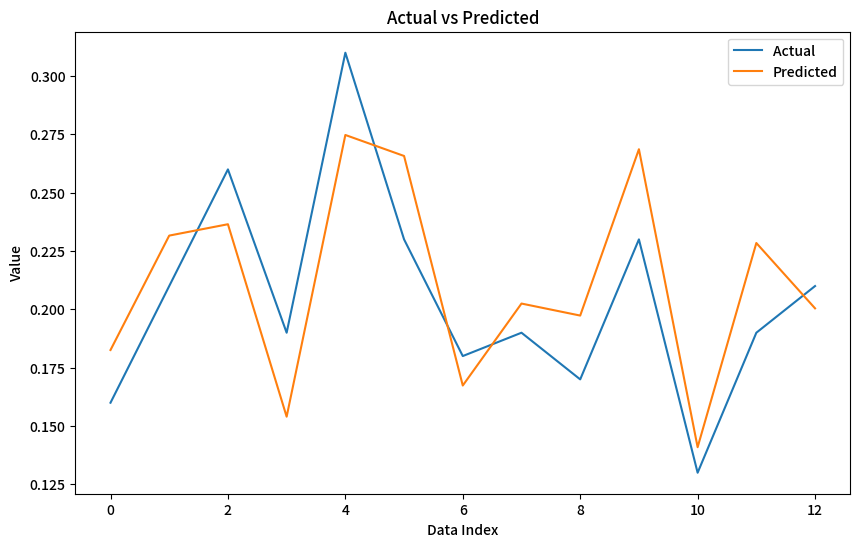

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# 훈련 세트와 테스트 세트로 데이터 나누기
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Linear Regression 모델 생성 및 훈련
model = LinearRegression()
model.fit(X_train, y_train)

# 테스트 데이터에 대한 예측 수행
y_pred = model.predict(X_test)

# Mean Squared Error (MSE) 계산
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error (MSE):", mse)

# Root Mean Squared Error (RMSE) 계산
rmse = mean_squared_error(y_test, y_pred, squared=False)
print("Root Mean Squared Error (RMSE):", rmse)

# Mean Absolute Error (MAE) 계산
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error (MAE):", mae)

# R-squared (Coefficient of Determination) 계산
r2 = r2_score(y_test, y_pred)
print("R-squared (R2):", r2)

# 예측 결과 비교를 위한 그래프
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title("Actual vs Predicted")
plt.xlabel("Data Index")
plt.ylabel("Value")
plt.legend()
plt.show()

####XGboost

Best Hyperparameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 50, 'subsample': 0.8}
Mean Squared Error (MSE): 0.0007767536050081933
RMSE: 0.027870299693548206
Mean Absolute Error (MAE): 0.024409473538398736
R-squared (R²): 0.6043660058879303
Train CV MSE: 0.0005623248613222827
Test CV MSE: 0.0013292139805243844
과적합 아닙니다
Rank 1: Feature 예금은행 기타 가계대출금, Importance: 0.5513707995414734
Rank 2: Feature 예금은행 주택담보 대출금, Importance: 0.10788396745920181
Rank 3: Feature 비은행예금취급기관_금액, Importance: 0.10706397145986557
Rank 4: Feature 기준금리, Importance: 0.09256879985332489
Rank 5: Feature 소비자물가지수, Importance: 0.07993514835834503
Rank 6: Feature 아파트매매가격지수, Importance: 0.04510122165083885
Rank 7: Feature 부동산지수, Importance: 0.016076218336820602


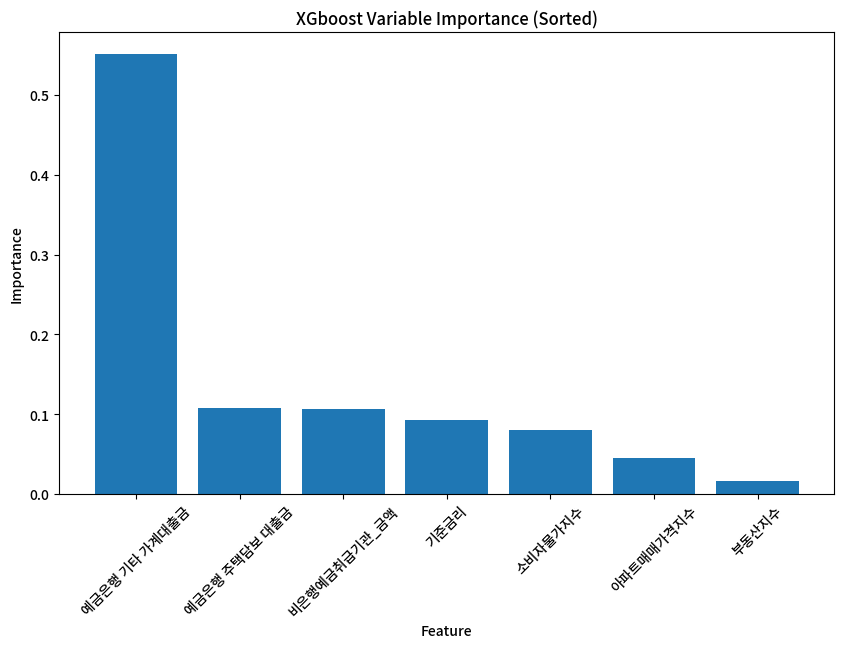

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold

# 데이터를 훈련 세트와 테스트 세트로 분할
X=X[['기준금리','예금은행 기타 가계대출금','소비자물가지수','예금은행 주택담보 대출금','아파트매매가격지수','부동산지수','비은행예금취급기관_금액']]
y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# xgboost 회귀 모델 생성
xgb_regressor = XGBRegressor(n_estimators=1000)


# 그리드 서치에 사용할 하이퍼파라미터 후보값 정의
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_child_weight': [1, 2, 3],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

# 그리드 서치를 사용하여 최적의 하이퍼파라미터 탐색
grid_search = GridSearchCV(xgb_regressor, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

# 최적의 하이퍼파라미터 출력
best_params = grid_search.best_params_
print(f"Best Hyperparameters: {best_params}")

# 최적의 모델로 테스트 세트 예측
best_xgb_regressor = grid_search.best_estimator_
y_pred = best_xgb_regressor.predict(X_test)


# 평균 제곱 오차 (Mean Squared Error, MSE)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error (MSE): {mse}")

# RMSE 계산
rmse = np.sqrt(mse)
print("RMSE:", rmse)

import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 평균 절대 오차 (Mean Absolute Error, MAE)
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error (MAE): {mae}")

# R-squared (R²)
r2 = r2_score(y_test, y_pred)
print(f"R-squared (R²): {r2}")

# 교차 검증으로 훈련 세트의 평균 제곱 오차 (MSE) 계산
train_cv_scores = cross_val_score(best_xgb_regressor, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
train_mse = -np.mean(train_cv_scores)  # 부호 변경하여 양수로 변환
print("Train CV MSE:", train_mse)

# 교차 검증으로 테스트 세트의 평균 제곱 오차 (MSE) 계산
test_cv_scores = cross_val_score(best_xgb_regressor, X_test, y_test, cv=5, scoring='neg_mean_squared_error')
test_mse = -np.mean(test_cv_scores)  # 부호 변경하여 양수로 변환
print("Test CV MSE:", test_mse)


# 과적합 여부 확인
if train_mse < test_mse:
    print("과적합 아닙니다")
else:
    print("과적합입니다")

#모델의 변수 중요도
importances = best_xgb_regressor.feature_importances_

# 변수 중요도 내림차순으로 정렬한 인덱스
sorted_indices = np.argsort(importances)[::-1]

# 정렬된 변수 중요도와 변수명 출력
for i, idx in enumerate(sorted_indices):
    print(f"Rank {i + 1}: Feature {X_train.columns[idx]}, Importance: {importances[idx]}")

# 변수 중요도 내림차순으로 정렬 및 시각화
sorted_indices = np.argsort(importances)[::-1]  # 중요도 내림차순으로 정렬된 인덱스
sorted_feature_names = [X_train.columns[i] for i in sorted_indices]  # 정렬된 특성 이름
sorted_importances = importances[sorted_indices]  # 정렬된 중요도

plt.figure(figsize=(10, 6))
plt.bar(sorted_feature_names, sorted_importances)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('XGboost Variable Importance (Sorted)')
plt.xticks(rotation=45)
plt.show()

##부산(busan) -12개월

In [ ]:
#연체 시차
chungbuk['3개월 후 연체율'] = chungbuk['가계대출 연체율'].shift(-3)
chungbuk['6개월 후 연체율'] = chungbuk['가계대출 연체율'].shift(-6)
chungbuk['12개월 후 연체율'] = chungbuk['가계대출 연체율'].shift(-12)
chungbuk = chungbuk.drop(columns=['날짜','지역'])
chungbuk

,실업률,고용률,어음부도율,지가변동률,상장회사수,비은행예금취급기관_금액,주택거래량,예금은행 기타 가계대출금,월세수급동향,매매수급동향,...,이혼율,교육비지출전망지수,부동산지수,부동산시장소비심리지수,가계대출 연체율,통화량,기준금리,3개월 후 연체율,6개월 후 연체율,12개월 후 연체율
0,2.9,63.1,0.01,0.253,0,19961.3,1463,3785.3,90.69,80.00,...,4.5,101,96.1,95.6,NaN,2700362,1.75,NaN,NaN,0.13
1,2.3,59.5,0.03,0.208,0,19964.8,1551,3767.4,75.90,69.52,...,12.5,104,95.8,79.2,NaN,2712850,1.75,NaN,NaN,0.13
2,3.6,64.3,0.09,0.214,1,19955.9,1467,3752.9,75.30,69.52,...,-0.2,104,95.6,96.7,NaN,2739656,1.75,NaN,NaN,0.15
3,3.0,65.4,0.57,0.252,1,20033.6,1727,3752.7,75.10,67.53,...,5.8,101,95.3,103.6,NaN,2763165,1.75,NaN,NaN,0.12
4,3.4,57.4,0.00,0.233,0,20136.5,1840,3768.2,77.69,68.13,...,-21.4,100,95.0,94.3,NaN,2760407,1.75,NaN,NaN,0.13
5,2.5,60.2,0.03,0.209,0,20234.5,1816,3791.2,78.29,67.93,...,-8.4,97,94.6,94.3,NaN,2773218,1.75,NaN,NaN,0.15
6,1.6,63.1,0.54,0.162,0,20431.8,1634,3796.3,77.89,67.13,...,6.5,100,94.3,120.5,NaN,2813933,1.75,NaN,0.13,0.11
7,4.4,62.3,1.16,0.144,0,20476.9,1969,3813.8,77.89,67.13,...,5.9,101,94.0,103.3,NaN,2807362,1.50,NaN,0.13,0.14
8,3.0,62.4,0.46,0.134,0,20530.2,2036,3842.3,77.69,66.73,...,-11.9,101,93.6,81.2,NaN,2848885,1.50,NaN,0.15,0.14
9,4.7,60.3,0.15,0.129,0,20501.4,1959,3854.5,77.69,65.94,...,-7.2,98,93.4,92.3,NaN,2853964,1.50,0.13,0.12,0.10


In [ ]:
#상관계수 분석
correlations =chungbuk.corr()['12개월 후 연체율']
sorted_features = correlations.abs().sort_values(ascending=False)
print(sorted_features)

12개월 후 연체율       1.000000
소비자물가지수          0.630579
교육비지출전망지수        0.626219
부동산지수            0.600076
전세수급동향           0.576910
기준금리             0.559981
아파트매매가격지수        0.506545
비은행예금취급기관_금액     0.504002
예금은행 주택담보 대출금    0.478952
주택거래량            0.427953
6개월 후 연체율        0.379635
통화량              0.375332
고용률              0.367019
가계대출 연체율         0.297899
실업률              0.233299
어음부도율            0.231600
지가변동률            0.138749
상장회사수            0.113980
예금은행 기타 가계대출금    0.082360
매매수급동향           0.081189
3개월 후 연체율        0.073436
이혼율              0.067635
부동산시장소비심리지수      0.013566
월세수급동향           0.011977
Name: 12개월 후 연체율, dtype: float64


In [ ]:
#z-score 정규화
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# Z-score 정규화
scaler = StandardScaler()
z_score_normalized = scaler.fit_transform(chungbuk)

# 정규화된 데이터프레임 생성
normalized_data = pd.DataFrame(z_score_normalized, columns=chungbuk.columns)
chungbuk = normalized_data
chungbuk

,실업률,고용률,어음부도율,지가변동률,상장회사수,비은행예금취급기관_금액,주택거래량,예금은행 기타 가계대출금,월세수급동향,매매수급동향,...,아파트매매가격지수,소비자물가지수,이혼율,교육비지출전망지수,부동산지수,부동산시장소비심리지수,가계대출 연체율,3개월 후 연체율,6개월 후 연체율,12개월 후 연체율
0,-0.181554,0.365331,-0.720252,0.778922,-0.640126,-1.223650,-1.313828,-0.989600,-0.008355,-0.825153,...,-0.828906,-0.974379,0.299862,0.681316,-0.603196,-0.677654,NaN,NaN,NaN,0.132745
1,-0.697551,-0.691519,-0.642465,0.233609,-0.640126,-1.222610,-1.212864,-1.047857,-1.001367,-1.495375,...,-0.882716,-1.002729,0.756635,1.632810,-0.668125,-1.759164,NaN,NaN,NaN,0.132745
2,0.420442,0.717614,-0.409103,0.306318,1.179180,-1.225256,-1.309239,-1.095049,-1.041651,-1.495375,...,-0.900653,-0.943972,0.031509,1.632810,-0.711411,-0.605113,NaN,NaN,NaN,0.829654
3,-0.095555,1.040541,1.457790,0.766804,1.179180,-1.202150,-1.010936,-1.095700,-1.055079,-1.622640,...,-0.990336,-1.013475,0.374088,0.681316,-0.776340,-0.150088,NaN,NaN,NaN,-0.215710
4,0.248443,-1.308015,-0.759145,0.536561,-0.640126,-1.171549,-0.881289,-1.045254,-0.881185,-1.584269,...,-1.044146,-0.917908,-1.178937,0.364152,-0.841269,-0.763383,NaN,NaN,NaN,0.132745
5,-0.525552,-0.486021,-0.642465,0.245727,-0.640126,-1.142406,-0.908825,-0.970398,-0.840900,-1.597059,...,-1.124861,-0.857093,-0.436683,-0.587342,-0.927840,-0.763383,NaN,NaN,NaN,0.829654
6,-1.299548,0.365331,1.341109,-0.323821,-0.640126,-1.083732,-1.117637,-0.953800,-0.867757,-1.648221,...,-1.178671,-0.893902,0.414055,0.364152,-0.992769,0.964396,NaN,NaN,0.132745,-0.564165
7,1.108438,0.130475,3.752512,-0.541946,-0.640126,-1.070320,-0.733285,-0.896844,-0.867757,-1.648221,...,-1.187640,-0.996099,0.379798,0.681316,-1.057698,-0.169871,NaN,NaN,0.132745,0.481199
8,-0.095555,0.159832,1.029960,-0.663127,-0.640126,-1.054470,-0.656415,-0.804089,-0.881185,-1.673802,...,-1.223513,-0.939628,-0.636520,0.681316,-1.144269,-1.627272,NaN,NaN,0.829654,0.481199
9,1.366436,-0.456664,-0.175741,-0.723717,-0.640126,-1.063035,-0.744758,-0.764383,-0.881185,-1.724325,...,-1.250418,-0.787361,-0.368167,-0.270177,-1.187555,-0.895275,NaN,0.132745,-0.215710,-0.912620


###상황에 맞는 변수 설정

In [ ]:
#시차 12개월 미루기
busan['12개월 후 연체율'] = busan['가계대출 연체율'].shift(-12)
x_data1 = busan.drop(columns = ['가계대출 연체율', '12개월 후 연체율']).reset_index()
y1_12month = busan['12개월 후 연체율'].reset_index()

#12개월 후 연체율을 종속변수로 삼을 때 변수설정
X = x_data1.iloc[:-12]#맨 아래 행 12개 제거
y = y1_12month.iloc[:-12]

<ipython-input-42-30de2cf96f88>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  busan['12개월 후 연체율'] = busan['가계대출 연체율'].shift(-12)


In [ ]:
busan = busan.drop(columns = ['가계대출 연체율'])
busan = busan.dropna()
busan

,지역,날짜,실업률,고용률,어음부도율,지가변동률,상장회사수,비은행예금취급기관_금액,주택거래량,예금은행 기타 가계대출금,...,예금은행 주택담보 대출금,아파트매매가격지수,소비자물가지수,이혼율,교육비지출전망지수,부동산지수,부동산시장소비심리지수,통화량,기준금리,12개월 후 연체율
183,부산광역시,2018-12,3.4,62.3,0.15,0.365,1,31469.1,3766,12418.3,...,36692.8,94.0,99.349,-12.2,99,90.3,69.4,2700362,1.75,0.34
199,부산광역시,2019-01,3.5,63.8,0.04,0.379,0,31297.8,3602,12299.9,...,36797.2,93.7,99.444,46.8,99,90.1,88.7,2712850,1.75,0.37
215,부산광역시,2019-02,2.4,64.2,0.06,0.312,0,31211.6,2794,12290.0,...,36986.8,93.7,99.795,-20.5,102,90.0,89.8,2739656,1.75,0.39
231,부산광역시,2019-03,4.6,58.9,0.07,0.301,0,31266.4,3401,12266.8,...,37143.8,92.5,99.624,11.8,101,89.8,83.1,2763165,1.75,0.35
247,부산광역시,2019-04,3.5,64.7,0.22,0.297,0,31234.2,3286,12295.7,...,37351.7,92.6,99.908,6.5,100,89.6,92.7,2760407,1.75,0.37
263,부산광역시,2019-05,2.3,59.3,0.01,0.304,0,31381.3,3524,12345.0,...,37425.9,91.9,99.889,-6.1,97,89.4,108.7,2773218,1.75,0.38
279,부산광역시,2019-06,3.2,62.9,0.61,0.300,0,31603.8,3364,12395.3,...,37705.7,91.3,99.823,-14.5,95,89.3,80.8,2813933,1.75,0.32
295,부산광역시,2019-07,1.9,63.7,0.00,0.279,0,31748.0,3731,12458.4,...,37954.3,91.3,99.567,-1.9,97,89.1,116.6,2807362,1.50,0.33
311,부산광역시,2019-08,5.6,58.8,0.00,0.257,0,31789.6,3781,12557.0,...,38490.9,90.9,99.690,-28.4,96,88.9,89.8,2848885,1.50,0.34
327,부산광역시,2019-09,2.9,62.8,0.09,0.250,0,31700.2,3887,12600.1,...,38790.0,91.0,100.269,9.2,98,88.8,87.3,2853964,1.50,0.29


In [ ]:
#상관계수 분석
correlations =busan.corr()['12개월 후 연체율']
sorted_features = correlations.abs().sort_values(ascending=False)
print(sorted_features)

12개월 후 연체율       1.000000
기준금리             0.937538
교육비지출전망지수        0.801006
매매수급동향           0.623582
주택거래량            0.609400
월세수급동향           0.609175
예금은행 기타 가계대출금    0.506787
고용률              0.421733
예금은행 주택담보 대출금    0.380609
실업률              0.303401
부동산시장소비심리지수      0.302990
통화량              0.264423
비은행예금취급기관_금액     0.231184
아파트매매가격지수        0.227757
소비자물가지수          0.145114
이혼율              0.069571
전세수급동향           0.063365
부동산지수            0.041691
지가변동률            0.038357
상장회사수            0.014376
어음부도율            0.002392
Name: 12개월 후 연체율, dtype: float64


<ipython-input-44-af6366029a94>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlations =busan.corr()['12개월 후 연체율']


In [ ]:
#가계대출 연체율로 할 때 변수 설정
X=x_chungbuk
y=ychungbuk_1
X,y

# 맨  행 12개 제거
X= X.iloc[12:]
y = y.iloc[12:]

X=X.drop(columns='index').reset_index()
y=y.drop(columns='index').reset_index()

X=X.drop(columns='index')
y=y.drop(columns='index')

###회귀분석 준비

In [ ]:
#상수항 추가
busan = sm.add_constant(busan,has_constant='add')
busan

,const,지역,날짜,실업률,고용률,어음부도율,지가변동률,상장회사수,비은행예금취급기관_금액,주택거래량,...,예금은행 주택담보 대출금,아파트매매가격지수,소비자물가지수,이혼율,교육비지출전망지수,부동산지수,부동산시장소비심리지수,통화량,기준금리,12개월 후 연체율
183,1.0,부산광역시,2018-12,3.4,62.3,0.15,0.365,1,31469.1,3766,...,36692.8,94.0,99.349,-12.2,99,90.3,69.4,2700362,1.75,0.34
199,1.0,부산광역시,2019-01,3.5,63.8,0.04,0.379,0,31297.8,3602,...,36797.2,93.7,99.444,46.8,99,90.1,88.7,2712850,1.75,0.37
215,1.0,부산광역시,2019-02,2.4,64.2,0.06,0.312,0,31211.6,2794,...,36986.8,93.7,99.795,-20.5,102,90.0,89.8,2739656,1.75,0.39
231,1.0,부산광역시,2019-03,4.6,58.9,0.07,0.301,0,31266.4,3401,...,37143.8,92.5,99.624,11.8,101,89.8,83.1,2763165,1.75,0.35
247,1.0,부산광역시,2019-04,3.5,64.7,0.22,0.297,0,31234.2,3286,...,37351.7,92.6,99.908,6.5,100,89.6,92.7,2760407,1.75,0.37
263,1.0,부산광역시,2019-05,2.3,59.3,0.01,0.304,0,31381.3,3524,...,37425.9,91.9,99.889,-6.1,97,89.4,108.7,2773218,1.75,0.38
279,1.0,부산광역시,2019-06,3.2,62.9,0.61,0.300,0,31603.8,3364,...,37705.7,91.3,99.823,-14.5,95,89.3,80.8,2813933,1.75,0.32
295,1.0,부산광역시,2019-07,1.9,63.7,0.00,0.279,0,31748.0,3731,...,37954.3,91.3,99.567,-1.9,97,89.1,116.6,2807362,1.50,0.33
311,1.0,부산광역시,2019-08,5.6,58.8,0.00,0.257,0,31789.6,3781,...,38490.9,90.9,99.690,-28.4,96,88.9,89.8,2848885,1.50,0.34
327,1.0,부산광역시,2019-09,2.9,62.8,0.09,0.250,0,31700.2,3887,...,38790.0,91.0,100.269,9.2,98,88.8,87.3,2853964,1.50,0.29


####다중공선성 검사

In [ ]:
#다중공선성

from statsmodels.stats.outliers_influence import variance_inflation_factor
#영향을 주는 이상치 모듈에서 분산팽창요인 가져오기

vif=pd.DataFrame() #vif라는 빈 데이터프레임 형성
vif["VIF Factor"]= [variance_inflation_factor(X.values,i)for i in range(X.shape[1])]
#vif에 "VIF Factor"라는 변수에 x_data의 값들의 분산팽창요인을 넣고 범위는 (x_data.shape[1])

vif["features"] = X.columns #"features"라는 변수에 x_data의 열변수들 입력
vif

TypeError: ignored

In [ ]:
#vif가 가장 높은 변수 제거해보기(하나하나씩 차근차근)

vif=pd.DataFrame()

X1=X.drop('부동산지수', axis=1)

vif["VIF Factor"]= [variance_inflation_factor(X1.values,i)for i in range(X1.shape[1])]

vif["features"] = X1.columns
vif

,VIF Factor,features
0,6.290039,const
1,1.746576,실업률
2,3.513098,고용률
3,1.720902,어음부도율
4,3.209243,지가변동률
5,2.170948,상장회사수
6,185.225472,비은행예금취급기관_금액
7,3.646755,주택거래량
8,22.665436,예금은행 기타 가계대출금
9,20.844927,월세수급동향


####선형회귀분석

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
import statsmodels.api as sm

ols_model = sm.OLS(y,X412)
result = ols_model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             12개월 후 연체율   R-squared:                       0.658
Model:                            OLS   Adj. R-squared:                  0.547
Method:                 Least Squares   F-statistic:                     5.957
Date:                Tue, 15 Aug 2023   Prob (F-statistic):           5.61e-05
Time:                        06:44:46   Log-Likelihood:                -37.082
No. Observations:                  42   AIC:                             96.16
Df Residuals:                      31   BIC:                             115.3
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.4683      0.174      2.686      0.012       0.113       0.824
실업률              -0.0556      0.121     -0.461      0.648      -0.302       0.191
어음부도율             0.0682      0.107      0.639      0.527      -0.149       0.286
지가변동률            -0.0783      0.257     -0.304      0.763      -0.603       0.447
상장회사수            -0.0124      0.111     -0.112      0.911      -0.238       0.213
주택거래량            -0.4283      0.141     -3.030      0.005      -0.717      -0.140
매매수급동향           -0.1640      0.147     -1.118      0.272      -0.463       0.135
전세수급동향            0.6576      0.269      2.442      0.021       0.108       1.207
예금은행 주택담보 대출금     0.3609      0.196      1.846      0.075      -0.038       0.760
이혼율              -0.0882      0.110     -0.803      0.428      -0.312       0.136
부동산시장소비심리지수       0.0687      0.117      0.588      0.561      -0.170       0.307
==============================================================================
Omnibus:                        3.780   Durbin-Watson:                   1.671
Prob(Omnibus):                  0.151   Jarque-Bera (JB):                2.844
Skew:                           0.327   Prob(JB):                        0.241
Kurtosis:                       4.094   Cond. No.                         5.80
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

###랜덤 포레스트 회귀로 변수 추출

<ipython-input-73-6b3f5cd5bf5c>:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Rank 1: Feature 예금은행 기타 가계대출금, Importance: 0.27335977821792967
Rank 2: Feature 지가변동률, Importance: 0.2698081052523499
Rank 3: Feature 월세수급동향, Importance: 0.0987825115959808
Rank 4: Feature 기준금리, Importance: 0.094840341318342
Rank 5: Feature 소비자물가지수, Importance: 0.04527082123035349
Rank 6: Feature 매매수급동향, Importance: 0.03275072623936114
Rank 7: Feature 예금은행 주택담보 대출금, Importance: 0.025475797628619238
Rank 8: Feature 통화량, Importance: 0.02028903300496413
Rank 9: Feature 이혼율, Importance: 0.018660152466206056
Rank 10: Feature 비은행예금취급기관_금액, Importance: 0.017478630475075446
Rank 11: Feature 고용률 , Importance: 0.01703451981541321
Rank 12: Feature 부동산시장소비심리지수, Importance: 0.014360055503394262
Rank 13: Feature 어음부도율, Importance: 0.014111105935015734
Rank 14: Feature 아파트매매가격지수, Importance: 0.010882892075809922
Rank 15: Feature 교육비지출전망지수, Importance: 0.01041516950934939
Rank 16: Feature 전세수급동향, Importance: 0.009139400949383206
Rank 17: Feature 부동산지수, Importance: 0.00749213268800866
Rank 18: Feature 주

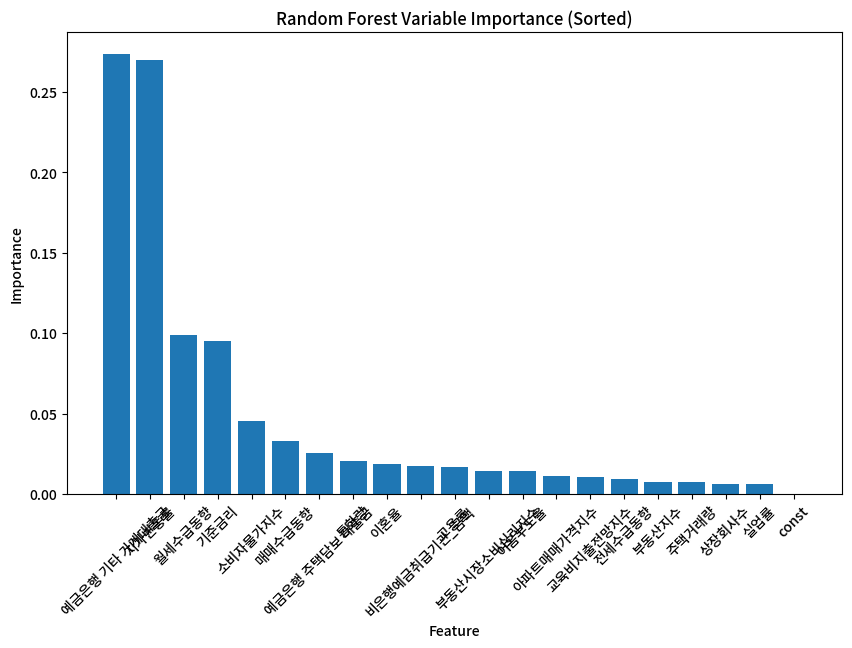

R-squared (R²): 0.4345288395904422


In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

rf_model.fit(X_train, y_train)

# 변수 중요도 추출
importances = rf_model.feature_importances_

# 변수 중요도 내림차순으로 정렬한 인덱스
sorted_indices = np.argsort(importances)[::-1]

# 정렬된 변수 중요도와 변수명 출력
for i, idx in enumerate(sorted_indices):
    print(f"Rank {i + 1}: Feature {X_train.columns[idx]}, Importance: {importances[idx]}")

# 변수 중요도 내림차순으로 정렬 및 시각화
sorted_indices = np.argsort(importances)[::-1]  # 중요도 내림차순으로 정렬된 인덱스
sorted_feature_names = [X_train.columns[i] for i in sorted_indices]  # 정렬된 특성 이름
sorted_importances = importances[sorted_indices]  # 정렬된 중요도

plt.figure(figsize=(10, 6))
plt.bar(sorted_feature_names, sorted_importances)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Random Forest Variable Importance (Sorted)')
plt.xticks(rotation=45)
plt.show()

#
y_pred = rf_model.predict(X_test)

# R-squared (R²)
r2 = r2_score(y_test, y_pred)
print(f"R-squared (R²): {r2}")

###정상성 ADF 검정

In [ ]:
from statsmodels.tsa.stattools import adfuller

# ADF 검정 수행
result = adfuller(X)

# 검정 결과 출력
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])

###머신러닝

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold

# 데이터를 훈련 세트와 테스트 세트로 분할
X=X[['전세수급동향', '소비자물가지수', '부동산지수', '비은행예금취급기관_금액', '교육비지출전망지수','아파트매매가격지수','통화량','고용률 ','예금은행 주택담보 대출금']]
y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 랜덤 포레스트 회귀 모델 생성
rf_regressor = RandomForestRegressor(random_state=42)


# 그리드 서치에 사용할 하이퍼파라미터 후보값 정의
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20,30],
    'min_samples_split': [2, 4, 8],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# 그리드 서치를 사용하여 최적의 하이퍼파라미터 탐색
grid_search = GridSearchCV(rf_regressor, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

# 최적의 하이퍼파라미터 출력
best_params = grid_search.best_params_
print(f"Best Hyperparameters: {best_params}")

# 최적의 모델로 테스트 세트 예측
best_rf_regressor = grid_search.best_estimator_
y_pred = best_rf_regressor.predict(X_test)


# 평균 제곱 오차 (Mean Squared Error, MSE)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error (MSE): {mse}")

# RMSE 계산
rmse = np.sqrt(mse)
print("RMSE:", rmse)

import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 평균 절대 오차 (Mean Absolute Error, MAE)
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error (MAE): {mae}")

# R-squared (R²)
r2 = r2_score(y_test, y_pred)
print(f"R-squared (R²): {r2}")

# 교차 검증으로 훈련 세트의 평균 제곱 오차 (MSE) 계산
train_cv_scores = cross_val_score(best_rf_regressor, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
train_mse = -np.mean(train_cv_scores)  # 부호 변경하여 양수로 변환
print("Train CV MSE:", train_mse)

# 교차 검증으로 테스트 세트의 평균 제곱 오차 (MSE) 계산
test_cv_scores = cross_val_score(best_rf_regressor, X_test, y_test, cv=5, scoring='neg_mean_squared_error')
test_mse = -np.mean(test_cv_scores)  # 부호 변경하여 양수로 변환
print("Test CV MSE:", test_mse)


# 과적합 여부 확인
if train_mse < test_mse:
    print("과적합 아닙니다")
else:
    print("과적합입니다")

#모델의 변수 중요도
importances = best_rf_regressor.feature_importances_

# 변수 중요도 내림차순으로 정렬한 인덱스
sorted_indices = np.argsort(importances)[::-1]

# 정렬된 변수 중요도와 변수명 출력
for i, idx in enumerate(sorted_indices):
    print(f"Rank {i + 1}: Feature {X_train.columns[idx]}, Importance: {importances[idx]}")

# 변수 중요도 내림차순으로 정렬 및 시각화
sorted_indices = np.argsort(importances)[::-1]  # 중요도 내림차순으로 정렬된 인덱스
sorted_feature_names = [X_train.columns[i] for i in sorted_indices]  # 정렬된 특성 이름
sorted_importances = importances[sorted_indices]  # 정렬된 중요도

plt.figure(figsize=(10, 6))
plt.bar(sorted_feature_names, sorted_importances)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Random Forest Variable Importance (Sorted)')
plt.xticks(rotation=45)
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:909: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1

Best Hyperparameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 50}
Mean Squared Error (MSE): 0.00021667513503885894
RMSE: 0.01471988909736955
Mean Absolute Error (MAE): 0.01165304029304029
R-squared (R²): 0.37511778461489487


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed whe

Train CV MSE: 0.000286240415248677
Test CV MSE: 0.0003907816086942557
과적합 아닙니다


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold

# 데이터를 훈련 세트와 테스트 세트로 분할
X=X[['기준금리', '부동산지수', '통화량', '비은행예금취급기관_금액', '전세수급동향']]
y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# xgboost 회귀 모델 생성
xgb_regressor = XGBRegressor(n_estimators=1000)


# 그리드 서치에 사용할 하이퍼파라미터 후보값 정의
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_child_weight': [1, 2, 3],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

# 그리드 서치를 사용하여 최적의 하이퍼파라미터 탐색
grid_search = GridSearchCV(xgb_regressor, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

# 최적의 하이퍼파라미터 출력
best_params = grid_search.best_params_
print(f"Best Hyperparameters: {best_params}")

# 최적의 모델로 테스트 세트 예측
best_xgb_regressor = grid_search.best_estimator_
y_pred = best_xgb_regressor.predict(X_test)


# 평균 제곱 오차 (Mean Squared Error, MSE)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error (MSE): {mse}")

# RMSE 계산
rmse = np.sqrt(mse)
print("RMSE:", rmse)

import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 평균 절대 오차 (Mean Absolute Error, MAE)
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error (MAE): {mae}")

# R-squared (R²)
r2 = r2_score(y_test, y_pred)
print(f"R-squared (R²): {r2}")

# 교차 검증으로 훈련 세트의 평균 제곱 오차 (MSE) 계산
train_cv_scores = cross_val_score(best_xgb_regressor, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
train_mse = -np.mean(train_cv_scores)  # 부호 변경하여 양수로 변환
print("Train CV MSE:", train_mse)

# 교차 검증으로 테스트 세트의 평균 제곱 오차 (MSE) 계산
test_cv_scores = cross_val_score(best_xgb_regressor, X_test, y_test, cv=5, scoring='neg_mean_squared_error')
test_mse = -np.mean(test_cv_scores)  # 부호 변경하여 양수로 변환
print("Test CV MSE:", test_mse)


# 과적합 여부 확인
if train_mse < test_mse:
    print("과적합 아닙니다")
else:
    print("과적합입니다")

#모델의 변수 중요도
importances = best_xgb_regressor.feature_importances_

# 변수 중요도 내림차순으로 정렬한 인덱스
sorted_indices = np.argsort(importances)[::-1]

# 정렬된 변수 중요도와 변수명 출력
for i, idx in enumerate(sorted_indices):
    print(f"Rank {i + 1}: Feature {X_train.columns[idx]}, Importance: {importances[idx]}")

# 변수 중요도 내림차순으로 정렬 및 시각화
sorted_indices = np.argsort(importances)[::-1]  # 중요도 내림차순으로 정렬된 인덱스
sorted_feature_names = [X_train.columns[i] for i in sorted_indices]  # 정렬된 특성 이름
sorted_importances = importances[sorted_indices]  # 정렬된 중요도

plt.figure(figsize=(10, 6))
plt.bar(sorted_feature_names, sorted_importances)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('XGboost Variable Importance (Sorted)')
plt.xticks(rotation=45)
plt.show()

## 전국(wjsrnr)

In [ ]:
wjsrnr=pd.read_excel('/content/레전드 찐찐찐막.xlsx',sheet_name='전국')

In [ ]:
#연체 시차
wjsrnr['3개월 후 연체율'] = wjsrnr['가계대출 연체율'].shift(-3)
wjsrnr['6개월 후 연체율'] = wjsrnr['가계대출 연체율'].shift(-6)
wjsrnr['12개월 후 연체율'] = wjsrnr['가계대출 연체율'].shift(-12)
wjsrnr = wjsrnr.drop(columns=['날짜','지역'])
wjsrnr

,실업률,고용률,어음부도율,지가변동률,상장회사수,비은행예금취급기관_금액,주택거래량,예금은행 기타 가계대출금,매매수급동향,월세수급동향,...,이혼건수,교육비지출전망지수,부동산지수,가계대출 연체율,부동산시장소비심리지수,통화량,기준금리,3개월 후 연체율,6개월 후 연체율,12개월 후 연체율
0,3.4,60.1,0.07,0.341,22,554832.8,55681,218819.4,94.73,92.12,...,-11.6,103,90.6,NaN,90.7,2700362,1.75,NaN,NaN,0.26
1,4.5,59.2,0.07,0.314,2,557684.8,50286,217410.3,90.67,88.36,...,8.7,105,90.5,NaN,90.0,2712850,1.75,NaN,NaN,0.29
2,4.7,59.4,0.08,0.265,4,558178.0,43444,217444.4,87.86,86.35,...,-15.3,104,90.4,NaN,92.7,2739656,1.75,NaN,NaN,0.30
3,4.3,60.4,0.14,0.300,8,559284.5,51357,217452.5,86.86,85.87,...,10.6,104,90.3,NaN,90.9,2763165,1.75,NaN,NaN,0.27
4,4.4,60.8,0.13,0.317,2,563606.2,57025,218299.6,86.93,85.65,...,5.1,102,90.1,NaN,87.7,2760407,1.75,NaN,NaN,0.29
5,4.0,61.5,0.08,0.330,8,567149.5,57103,220345.2,88.24,85.72,...,3.4,101,89.9,NaN,91.3,2773218,1.75,NaN,NaN,0.30
6,4.0,61.6,0.09,0.323,5,569779.1,54893,221776.1,92.43,86.20,...,-12.0,101,89.8,NaN,97.9,2813933,1.75,NaN,0.26,0.25
7,3.9,61.5,0.08,0.337,10,574907.6,67349,223824.3,89.80,85.40,...,9.4,100,89.7,NaN,101.7,2807362,1.50,NaN,0.29,0.26
8,3.0,61.4,0.05,0.330,11,578211.9,66506,226568.7,87.62,84.63,...,-4.7,100,89.7,NaN,103.5,2848885,1.50,NaN,0.30,0.27
9,3.1,61.5,0.07,0.322,6,580335.2,64088,227415.5,85.67,83.77,...,-0.5,101,89.7,NaN,108.4,2853964,1.50,0.26,0.27,0.22


12개월 후 연체율       1.000000
기준금리             0.838982
예금은행 기타 가계대출금    0.818113
아파트매매가격지수        0.750194
부동산시장소비심리지수      0.736646
매매수급동향           0.735776
전세수급동향           0.700915
지가변동률            0.659726
월세수급동향           0.559659
어음부도율            0.455443
6개월 후 연체율        0.353332
가계대출 연체율         0.339684
예금은행 주택담보 대출금    0.252373
실업자수             0.201357
부동산지수            0.186063
소비자물가지수          0.140092
비은행예금취급기관_금액     0.088493
실업률              0.081427
3개월 후 연체율        0.060582
통화량              0.048986
상장회사수            0.046362
고용률              0.042237
이혼건수             0.038981
주택거래량            0.011663
Name: 12개월 후 연체율, dtype: float64


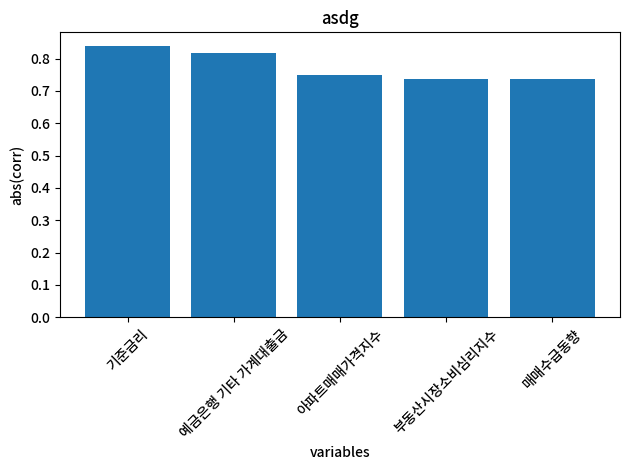

In [ ]:
#상관계수 분석
correlations =wjsrnr.corr()['12개월 후 연체율']
sorted_features = correlations.abs().sort_values(ascending=False)
sorted_featured=sorted_features[1:6]
print(sorted_features)

plt.bar(sorted_featured.index , sorted_featured)
plt.xlabel('variables')
plt.ylabel('abs(corr)')
plt.title('asdg')
plt.xticks(rotation=45)
plt.tight_layout()

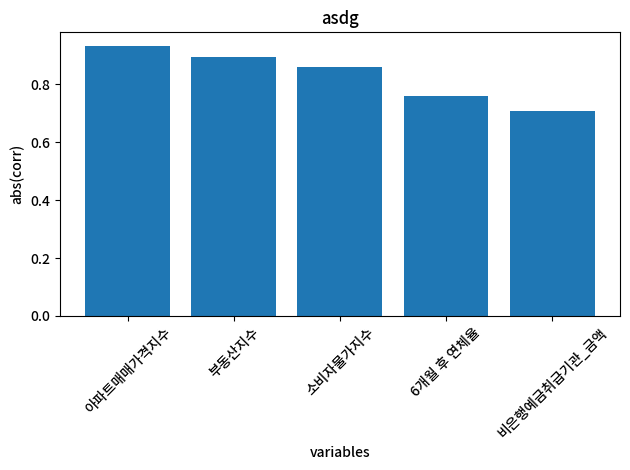

In [ ]:
#상관계수 분석 (전북 -> 기준금리 3개월 때 유효)(제주-> 기준금리 6개월 때 유효)(충남 -> 12개월 때 유효)(충북 -> 6개월 떄 유효)
correlations =jeonbuk.corr()['12개월 후 연체율']
sorted_features = correlations.abs().sort_values(ascending=False)
sorted_featured=sorted_features[1:6]


plt.bar(sorted_featured.index , sorted_featured)
plt.xlabel('variables')
plt.ylabel('abs(corr)')
plt.title('asdg')
plt.xticks(rotation=45)
plt.tight_layout()

In [ ]:
x_wjsrnr=wjsrnr.drop(columns=['가계대출 연체율','3개월 후 연체율','6개월 후 연체율','12개월 후 연체율']).reset_index()
ywjsrnr_1 = wjsrnr["가계대출 연체율"].reset_index()
ywjsrnr_3month = wjsrnr["3개월 후 연체율"].reset_index()
ywjsrnr_6month = wjsrnr["6개월 후 연체율"].reset_index()
ywjsrnr_12month = wjsrnr["12개월 후 연체율"].reset_index()


In [ ]:
#가계대출 연체율로 할 때 변수 설정
X=x_wjsrnr
y=ywjsrnr_1
X,y

# 맨  행 12개 제거
X= X.iloc[12:]
y = y.iloc[12:]

X=X.drop(columns='index').reset_index()
y=y.drop(columns='index').reset_index()

X=X.drop(columns='index')
y=y.drop(columns='index')

In [ ]:
#12개월 후 연체율을 종속변수로 삼을 때, 변수 설정
#변수 설정

# 맨 아래 행 12개 제거
X= x_chungbuk.iloc[:-12]
y = ychungbuk_12month.iloc[:-12]

X=X.drop(columns='index')
y=y.drop(columns='index')
y

,12개월 후 연체율
0,0.13
1,0.13
2,0.15
3,0.12
4,0.13
5,0.15
6,0.11
7,0.14
8,0.14
9,0.10


In [ ]:
#상수항 추가
X = sm.add_constant(X,has_constant='add')
X

,const,실업률,고용률,어음부도율,지가변동률,상장회사수,비은행예금취급기관_금액,주택거래량,예금은행 기타 가계대출금,월세수급동향,...,전세수급동향,예금은행 주택담보 대출금,아파트매매가격지수,소비자물가지수,이혼율,교육비지출전망지수,부동산지수,부동산시장소비심리지수,통화량,기준금리
0,1.0,2.9,63.1,0.01,0.253,0,19961.3,1463,3785.3,90.69,...,93.79,6358.7,89.7,99.153,4.5,101,96.1,95.6,2700362,1.75
1,1.0,2.3,59.5,0.03,0.208,0,19964.8,1551,3767.4,75.90,...,77.09,6399.2,89.1,99.029,12.5,104,95.8,79.2,2712850,1.75
2,1.0,3.6,64.3,0.09,0.214,1,19955.9,1467,3752.9,75.30,...,77.69,6370.3,88.9,99.286,-0.2,104,95.6,96.7,2739656,1.75
3,1.0,3.0,65.4,0.57,0.252,1,20033.6,1727,3752.7,75.10,...,76.69,6329.0,87.9,98.982,5.8,101,95.3,103.6,2763165,1.75
4,1.0,3.4,57.4,0.00,0.233,0,20136.5,1840,3768.2,77.69,...,77.69,6286.2,87.3,99.400,-21.4,100,95.0,94.3,2760407,1.75
5,1.0,2.5,60.2,0.03,0.209,0,20234.5,1816,3791.2,78.29,...,78.09,6249.3,86.4,99.666,-8.4,97,94.6,94.3,2773218,1.75
6,1.0,1.6,63.1,0.54,0.162,0,20431.8,1634,3796.3,77.89,...,76.89,6204.1,85.8,99.505,6.5,100,94.3,120.5,2813933,1.75
7,1.0,4.4,62.3,1.16,0.144,0,20476.9,1969,3813.8,77.89,...,77.49,6259.8,85.7,99.058,5.9,101,94.0,103.3,2807362,1.50
8,1.0,3.0,62.4,0.46,0.134,0,20530.2,2036,3842.3,77.69,...,76.89,6435.9,85.3,99.305,-11.9,101,93.6,81.2,2848885,1.50
9,1.0,4.7,60.3,0.15,0.129,0,20501.4,1959,3854.5,77.69,...,77.49,6498.1,85.0,99.971,-7.2,98,93.4,92.3,2853964,1.50


<ipython-input-84-6b3f5cd5bf5c>:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Rank 1: Feature 전세수급동향, Importance: 0.1306854879416907
Rank 2: Feature 소비자물가지수, Importance: 0.1143160885641973
Rank 3: Feature 부동산지수, Importance: 0.10742496044488044
Rank 4: Feature 비은행예금취급기관_금액, Importance: 0.10544944111795376
Rank 5: Feature 교육비지출전망지수, Importance: 0.09721246008821514
Rank 6: Feature 아파트매매가격지수, Importance: 0.09425147995434435
Rank 7: Feature 통화량, Importance: 0.08848113796959127
Rank 8: Feature 고용률 , Importance: 0.08327760520823586
Rank 9: Feature 예금은행 주택담보 대출금, Importance: 0.06519956387788864
Rank 10: Feature 기준금리, Importance: 0.023076988867471938
Rank 11: Feature 이혼율, Importance: 0.016601069495915416
Rank 12: Feature 주택거래량, Importance: 0.014789652543797282
Rank 13: Feature 매매수급동향, Importance: 0.01140992226734791
Rank 14: Feature 지가변동률, Importance: 0.010131929313162008
Rank 15: Feature 어음부도율, Importance: 0.008868080510803497
Rank 16: Feature 실업률, Importance: 0.008487355933269424
Rank 17: Feature 부동산시장소비심리지수, Importance: 0.007660294300297221
Rank 18: Feature 예금은행 기타 가계

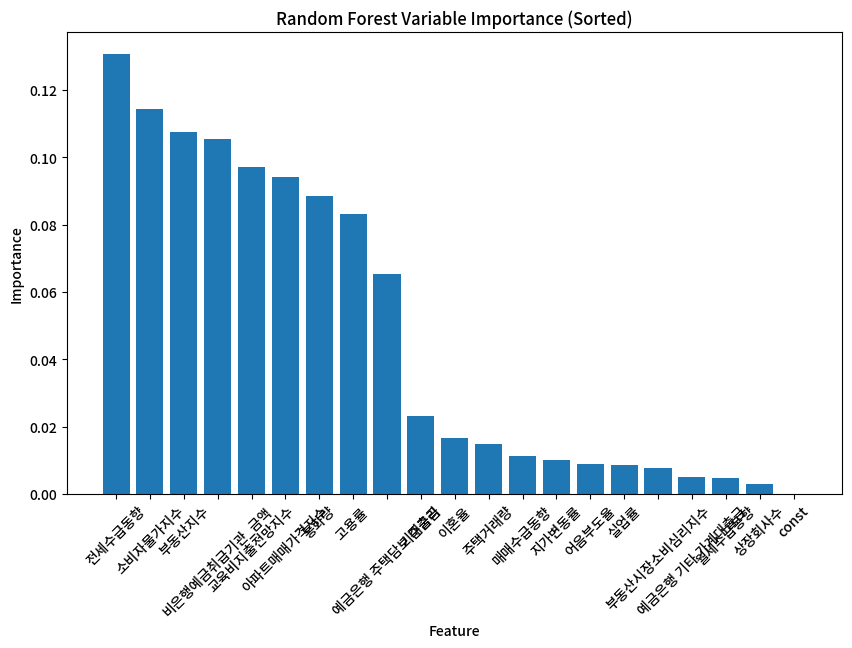

R-squared (R²): 0.47783037542662143


In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

rf_model.fit(X_train, y_train)

# 변수 중요도 추출
importances = rf_model.feature_importances_

# 변수 중요도 내림차순으로 정렬한 인덱스
sorted_indices = np.argsort(importances)[::-1]

# 정렬된 변수 중요도와 변수명 출력
for i, idx in enumerate(sorted_indices):
    print(f"Rank {i + 1}: Feature {X_train.columns[idx]}, Importance: {importances[idx]}")

# 변수 중요도 내림차순으로 정렬 및 시각화
sorted_indices = np.argsort(importances)[::-1]  # 중요도 내림차순으로 정렬된 인덱스
sorted_feature_names = [X_train.columns[i] for i in sorted_indices]  # 정렬된 특성 이름
sorted_importances = importances[sorted_indices]  # 정렬된 중요도

plt.figure(figsize=(10, 6))
plt.bar(sorted_feature_names, sorted_importances)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Random Forest Variable Importance (Sorted)')
plt.xticks(rotation=45)
plt.show()

#
y_pred = rf_model.predict(X_test)

# R-squared (R²)
r2 = r2_score(y_test, y_pred)
print(f"R-squared (R²): {r2}")

##경상남도(kyungnam)

In [ ]:
#연체 시차
kyungnam['3개월 후 연체율'] = kyungnam['가계대출 연체율'].shift(-3)
kyungnam['6개월 후 연체율'] = kyungnam['가계대출 연체율'].shift(-6)
kyungnam['12개월 후 연체율'] = kyungnam['가계대출 연체율'].shift(-12)
kyungnam = kyungnam.drop(columns=['날짜','지역'])
kyungnam

<ipython-input-10-1166796586f7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kyungnam['3개월 후 연체율'] = kyungnam['가계대출 연체율'].shift(-3)
<ipython-input-10-1166796586f7>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kyungnam['6개월 후 연체율'] = kyungnam['가계대출 연체율'].shift(-6)
<ipython-input-10-1166796586f7>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyd

,실업률,고용률,어음부도율,지가변동률,상장회사수,비은행예금취급기관_금액,주택거래량,예금은행 기타 가계대출금,월세수급동향,매매수급동향,...,소비자물가지수,이혼율,교육비지출전망지수,부동산지수,부동산시장소비심리지수,가계대출 연체율,실업자수(1000명),3개월 후 연체율,6개월 후 연체율,12개월 후 연체율
2,3.8,62.8,0.13,0.090,0,41458.0,3267,8724.2,59.40,53.55,...,99.169,-18.4,99,98.1,73.6,NaN,53,NaN,NaN,0.33
18,1.6,62.9,0.17,0.080,0,41370.2,2798,8670.8,58.62,54.89,...,99.064,6.6,103,97.7,112.6,NaN,33,NaN,NaN,0.38
34,2.4,64.3,0.89,0.072,0,41291.3,2732,8661.7,57.88,53.23,...,99.427,3.1,101,97.4,79.0,NaN,24,NaN,NaN,0.37
50,2.2,63.9,0.10,0.082,0,41213.4,3294,8618.8,54.06,50.58,...,99.121,-16.9,102,97.2,92.3,NaN,29,NaN,NaN,0.32
66,3.0,60.8,0.54,0.092,0,41354.9,3602,8623.4,55.64,50.83,...,99.475,-1.9,99,96.9,101.5,NaN,270,NaN,NaN,0.33
82,2.7,59.2,0.00,0.066,0,41404.3,3117,8682.3,53.40,49.75,...,99.599,-5.5,100,96.6,95.8,NaN,314,NaN,NaN,0.33
98,2.9,59.8,0.01,0.046,0,41416.2,2972,8679.2,52.07,48.92,...,99.427,5.9,99,96.3,93.3,NaN,175,NaN,0.33,0.24
114,3.0,62.9,0.05,0.049,0,41423.4,3291,8694.6,60.78,58.62,...,99.102,-7.8,94,95.9,114.5,NaN,84,NaN,0.38,0.26
130,4.9,62.2,0.03,0.008,1,41398.1,3040,8733.9,60.12,56.72,...,99.140,39.4,100,95.5,113.0,NaN,73,NaN,0.37,0.27
146,2.7,59.5,0.11,-0.003,0,41477.3,3000,8713.5,59.95,55.56,...,99.618,-2.8,97,95.1,78.6,NaN,55,0.33,0.32,0.22


In [ ]:
#상관계수 분석
correlations =kyungnam.corr()['가계대출 연체율']
sorted_features = correlations.abs().sort_values(ascending=False)
print(sorted_features)

가계대출 연체율         1.000000
3개월 후 연체율        0.789837
지가변동률            0.781238
부동산지수            0.751963
아파트매매가격지수        0.745753
월세수급동향           0.658274
예금은행 기타 가계대출금    0.562128
매매수급동향           0.512738
전세수급동향           0.509113
비은행예금취급기관_금액     0.431249
6개월 후 연체율        0.339030
교육비지출전망지수        0.260220
소비자물가지수          0.240088
예금은행 주택담보 대출금    0.237953
실업자수(1000명)      0.203365
실업률              0.185489
이혼율              0.152783
고용률              0.133750
주택거래량            0.120058
상장회사수            0.080331
부동산시장소비심리지수      0.078487
12개월 후 연체율       0.039585
어음부도율            0.012551
Name: 가계대출 연체율, dtype: float64


#강원도(kangwon)

####시차변수 만들기

In [ ]:
#연체 시차
kangwon['3개월 후 연체율'] = kangwon['가계대출 연체율'].shift(-3)
kangwon['6개월 후 연체율'] = kangwon['가계대출 연체율'].shift(-6)
kangwon['12개월 후 연체율'] = kangwon['가계대출 연체율'].shift(-12)
kangwon = kangwon.drop(columns=['날짜','지역'])
kangwon

<ipython-input-126-1b2a5ab41938>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kangwon['3개월 후 연체율'] = kangwon['가계대출 연체율'].shift(-3)
<ipython-input-126-1b2a5ab41938>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kangwon['6개월 후 연체율'] = kangwon['가계대출 연체율'].shift(-6)
<ipython-input-126-1b2a5ab41938>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyda

,실업률,고용률,어음부도율,지가변동률,상장회사수,비은행예금취급기관_금액,주택거래량,예금은행 기타 가계대출금,월세수급동향,매매수급동향,...,아파트매매가격지수,소비자물가지수,이혼율,교육비지출전망지수,부동산지수,부동산시장소비심리지수,가계대출 연체율,3개월 후 연체율,6개월 후 연체율,12개월 후 연체율
0,4.2,61.9,0.18,0.272,1,15843.1,1540,4166.3,84.34,75.51,...,92.6,98.662,40.6,97,98.0,78.6,NaN,NaN,NaN,0.13
16,2.4,63.3,0.09,0.254,0,15801.7,1498,4125.5,82.40,75.00,...,91.6,98.577,21.5,101,97.8,102.5,NaN,NaN,NaN,0.13
32,2.8,59.3,0.24,0.215,0,15836.1,1441,4130.2,83.42,76.28,...,91.1,99.011,-19.7,98,97.7,81.0,NaN,NaN,NaN,0.14
48,3.7,63.6,0.06,0.238,0,15819.1,1767,4125.3,79.08,74.49,...,90.6,98.964,-7.7,100,97.4,94.1,NaN,NaN,NaN,0.13
64,2.8,65.5,0.12,0.257,0,15883.9,1967,4129.0,76.79,70.92,...,89.2,99.351,-4.3,97,97.2,103.1,NaN,NaN,NaN,0.13
80,3.2,58.7,0.00,0.249,0,15958.4,1802,4155.5,74.74,69.90,...,89.0,99.568,12.2,97,96.9,94.5,NaN,NaN,NaN,0.15
96,2.4,59.3,0.02,0.227,0,16031.7,1648,4161.7,74.49,69.64,...,88.9,99.483,7.9,99,96.6,104.7,NaN,NaN,0.13,0.12
112,2.3,61.2,0.29,0.240,0,16029.4,1793,4174.4,72.70,66.84,...,87.5,99.134,21.2,99,96.3,120.7,NaN,NaN,0.13,0.12
128,3.6,62.4,0.16,0.213,0,16086.3,1719,4208.3,72.19,66.58,...,88.0,99.370,3.7,97,95.9,106.5,NaN,NaN,0.14,0.13
144,3.0,62.8,0.01,0.188,1,16099.4,1673,4197.5,71.94,66.84,...,87.1,99.814,-3.0,99,95.5,77.6,NaN,0.13,0.13,0.11


In [ ]:
#상관계수 분석
correlations =kangwon.corr()['12개월 후 연체율']
sorted_features = correlations.abs().sort_values(ascending=False)
print(sorted_features)

12개월 후 연체율       1.000000
부동산지수            0.721210
소비자물가지수          0.708176
전세수급동향           0.705025
아파트매매가격지수        0.677375
비은행예금취급기관_금액     0.562349
교육비지출전망지수        0.361948
예금은행 주택담보 대출금    0.357508
고용률              0.342564
실업률              0.318006
6개월 후 연체율        0.294664
주택거래량            0.244987
지가변동률            0.235560
월세수급동향           0.181213
어음부도율            0.164857
이혼율              0.161639
상장회사수            0.118122
예금은행 기타 가계대출금    0.110025
가계대출 연체율         0.107859
3개월 후 연체율        0.057064
매매수급동향           0.046443
부동산시장소비심리지수      0.043222
Name: 12개월 후 연체율, dtype: float64


####정규화

In [ ]:
#z-score 정규화
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# Z-score 정규화
scaler = StandardScaler()
z_score_normalized = scaler.fit_transform(kangwon)

# 정규화된 데이터프레임 생성
normalized_data = pd.DataFrame(z_score_normalized, columns=kangwon.columns)
kangwon = normalized_data
kangwon

,실업률,고용률,어음부도율,지가변동률,상장회사수,비은행예금취급기관_금액,주택거래량,예금은행 기타 가계대출금,월세수급동향,매매수급동향,...,아파트매매가격지수,소비자물가지수,이혼율,교육비지출전망지수,부동산지수,부동산시장소비심리지수,가계대출 연체율,3개월 후 연체율,6개월 후 연체율,12개월 후 연체율
0,1.103235,0.170765,0.208964,1.146624,2.828427,-1.215865,-1.184624,-0.702333,-0.430738,-1.126391,...,-0.659247,-1.059170,2.052011,-0.322725,-0.417641,-1.703068,NaN,NaN,NaN,0.157439
1,-0.778071,0.625338,-0.226901,0.886526,-0.353553,-1.230715,-1.236108,-0.857758,-0.558348,-1.158757,...,-0.747082,-1.077528,0.997743,1.298405,-0.474664,-0.227617,NaN,NaN,NaN,0.157439
2,-0.360003,-0.673441,0.499541,0.322981,-0.353553,-1.218376,-1.305980,-0.839853,-0.491254,-1.077526,...,-0.790999,-0.983795,-1.276387,0.082558,-0.503175,-1.554906,NaN,NaN,NaN,0.570716
3,0.580650,0.722747,-0.372190,0.655328,-0.353553,-1.224473,-0.906361,-0.858519,-0.776731,-1.191123,...,-0.834917,-0.993946,-0.614019,0.893123,-0.588710,-0.746186,NaN,NaN,NaN,0.157439
4,-0.360003,1.339667,-0.081613,0.929876,-0.353553,-1.201230,-0.661196,-0.844425,-0.927363,-1.417682,...,-0.957885,-0.910364,-0.426348,-0.322725,-0.645733,-0.190576,NaN,NaN,NaN,0.157439
5,0.058065,-0.868258,-0.662766,0.814277,-0.353553,-1.174508,-0.863457,-0.743475,-1.062209,-1.482413,...,-0.975452,-0.863498,0.484408,-0.322725,-0.731268,-0.721492,NaN,NaN,NaN,0.983993
6,-0.778071,-0.673441,-0.565907,0.496380,-0.353553,-1.148216,-1.052235,-0.719856,-1.078653,-1.498913,...,-0.984235,-0.881855,0.247059,0.487840,-0.816802,-0.091801,NaN,NaN,0.157439,-0.255838
7,-0.882588,-0.056521,0.741689,0.684228,-0.353553,-1.149041,-0.874490,-0.671476,-1.196396,-1.676607,...,-1.107204,-0.957230,0.981183,0.487840,-0.902337,0.895948,NaN,NaN,0.157439,-0.255838
8,0.476133,0.333113,0.112105,0.294082,-0.353553,-1.128632,-0.965201,-0.542336,-1.229943,-1.693107,...,-1.063287,-0.906260,0.015230,-0.322725,-1.016383,0.019321,NaN,NaN,0.570716,0.157439
9,-0.150969,0.462991,-0.614337,-0.067165,2.828427,-1.123933,-1.021589,-0.583478,-1.246388,-1.676607,...,-1.142338,-0.810368,-0.354592,0.487840,-1.130429,-1.764802,NaN,0.157439,0.157439,-0.669115


####회귀분석 준비

######변수 추출

In [ ]:
x_kangwon=kangwon.drop(columns=['가계대출 연체율','3개월 후 연체율','6개월 후 연체율','12개월 후 연체율']).reset_index()
ykangwon_1 = kangwon["가계대출 연체율"].reset_index()
ykangwon_3month = kangwon["3개월 후 연체율"].reset_index()
ykangwon_6month = kangwon["6개월 후 연체율"].reset_index()
ykangwon_12month = kangwon["12개월 후 연체율"].reset_index()
ykangwon_12month

,index,12개월 후 연체율
0,0,0.157439
1,1,0.157439
2,2,0.570716
3,3,0.157439
4,4,0.157439
5,5,0.983993
6,6,-0.255838
7,7,-0.255838
8,8,0.157439
9,9,-0.669115


In [ ]:
# 데이터 타입을 실수로 변경
x_kangwon = x_kangwon.astype(float)

In [ ]:
#12개월 후 연체율을 종속변수로 삼을 때, 변수 설정
#변수 설정

# 맨 아래 행 12개 제거
X= x_kangwon.iloc[:-12]
y = ykangwon_12month.iloc[:-12]

X=X.drop(columns='index')
y=y.drop(columns='index')
y

,12개월 후 연체율
0,0.157439
1,0.157439
2,0.570716
3,0.157439
4,0.157439
5,0.983993
6,-0.255838
7,-0.255838
8,0.157439
9,-0.669115


In [ ]:
#상수항 추가
X = sm.add_constant(X,has_constant='add')
X

,const,실업률,고용률,어음부도율,지가변동률,상장회사수,비은행예금취급기관_금액,주택거래량,예금은행 기타 가계대출금,월세수급동향,매매수급동향,전세수급동향,예금은행 주택담보 대출금,아파트매매가격지수,소비자물가지수,이혼율,교육비지출전망지수,부동산지수,부동산시장소비심리지수
0,1.0,1.103235,0.170765,0.208964,1.146624,2.828427,-1.215865,-1.184624,-0.702333,-0.430738,-1.126391,-0.421784,-2.232213,-0.659247,-1.059170,2.052011,-0.322725,-0.417641,-1.703068
1,1.0,-0.778071,0.625338,-0.226901,0.886526,-0.353553,-1.230715,-1.236108,-0.857758,-0.558348,-1.158757,-0.482807,-1.934021,-0.747082,-1.077528,0.997743,1.298405,-0.474664,-0.227617
2,1.0,-0.360003,-0.673441,0.499541,0.322981,-0.353553,-1.218376,-1.305980,-0.839853,-0.491254,-1.077526,-0.466578,-1.876809,-0.790999,-0.983795,-1.276387,0.082558,-0.503175,-1.554906
3,1.0,0.580650,0.722747,-0.372190,0.655328,-0.353553,-1.224473,-0.906361,-0.858519,-0.776731,-1.191123,-0.714563,-1.658943,-0.834917,-0.993946,-0.614019,0.893123,-0.588710,-0.746186
4,1.0,-0.360003,1.339667,-0.081613,0.929876,-0.353553,-1.201230,-0.661196,-0.844425,-0.927363,-1.417682,-0.863874,-1.371279,-0.957885,-0.910364,-0.426348,-0.322725,-0.645733,-0.190576
5,1.0,0.058065,-0.868258,-0.662766,0.814277,-0.353553,-1.174508,-0.863457,-0.743475,-1.062209,-1.482413,-0.963198,-1.411099,-0.975452,-0.863498,0.484408,-0.322725,-0.731268,-0.721492
6,1.0,-0.778071,-0.673441,-0.565907,0.496380,-0.353553,-1.148216,-1.052235,-0.719856,-1.078653,-1.498913,-0.963198,-1.330543,-0.984235,-0.881855,0.247059,0.487840,-0.816802,-0.091801
7,1.0,-0.882588,-0.056521,0.741689,0.684228,-0.353553,-1.149041,-0.874490,-0.671476,-1.196396,-1.676607,-1.112508,-1.238088,-1.107204,-0.957230,0.981183,0.487840,-0.902337,0.895948
8,1.0,0.476133,0.333113,0.112105,0.294082,-0.353553,-1.128632,-0.965201,-0.542336,-1.229943,-1.693107,-1.128738,-0.962323,-1.063287,-0.906260,0.015230,-0.322725,-1.016383,0.019321
9,1.0,-0.150969,0.462991,-0.614337,-0.067165,2.828427,-1.123933,-1.021589,-0.583478,-1.246388,-1.676607,-1.145616,-0.869868,-1.142338,-0.810368,-0.354592,0.487840,-1.130429,-1.764802


###### 다중공선성 검사

In [ ]:
#다중공선성

from statsmodels.stats.outliers_influence import variance_inflation_factor
#영향을 주는 이상치 모듈에서 분산팽창요인 가져오기

vif=pd.DataFrame() #vif라는 빈 데이터프레임 형성
vif["VIF Factor"]= [variance_inflation_factor(X.values,i)for i in range(X.shape[1])]
#vif에 "VIF Factor"라는 변수에 x_data의 값들의 분산팽창요인을 넣고 범위는 (x_data.shape[1])

vif["features"] = X.columns #"features"라는 변수에 x_data의 열변수들 입력
vif

,VIF Factor,features
0,11.457488,const
1,1.578622,실업률
2,2.032054,고용률
3,1.271786,어음부도율
4,11.535708,지가변동률
5,1.571819,상장회사수
6,252.023083,비은행예금취급기관_금액
7,9.752393,주택거래량
8,27.490880,예금은행 기타 가계대출금
9,42.095820,월세수급동향


In [ ]:
#vif가 가장 높은 변수 제거해보기(하나하나씩 차근차근)

vif=pd.DataFrame()

X1=X.drop('아파트매매가격지수', axis=1)

vif["VIF Factor"]= [variance_inflation_factor(X1.values,i)for i in range(X1.shape[1])]

vif["features"] = X1.columns
vif

,VIF Factor,features
0,7.849828,const
1,1.575810,실업률
2,2.015435,고용률
3,1.258163,어음부도율
4,10.561056,지가변동률
5,1.513511,상장회사수
6,251.641408,비은행예금취급기관_금액
7,8.764401,주택거래량
8,27.315916,예금은행 기타 가계대출금
9,41.558625,월세수급동향


In [ ]:
#vif가 가장 높은 변수 제거해보기(하나하나씩 차근차근)

vif=pd.DataFrame()

X2=X1.drop('비은행예금취급기관_금액', axis=1)

vif["VIF Factor"]= [variance_inflation_factor(X2.values,i)for i in range(X2.shape[1])]

vif["features"] = X2.columns
vif

,VIF Factor,features
0,7.473982,const
1,1.571604,실업률
2,2.011855,고용률
3,1.256662,어음부도율
4,9.482751,지가변동률
5,1.509616,상장회사수
6,8.357958,주택거래량
7,26.292991,예금은행 기타 가계대출금
8,40.050674,월세수급동향
9,5.657286,매매수급동향


In [ ]:
#vif가 가장 높은 변수 제거해보기(하나하나씩 차근차근)

vif=pd.DataFrame()

X3=X2.drop('부동산지수', axis=1)

vif["VIF Factor"]= [variance_inflation_factor(X3.values,i)for i in range(X3.shape[1])]

vif["features"] = X3.columns
vif

,VIF Factor,features
0,7.415690,const
1,1.483406,실업률
2,1.903579,고용률
3,1.199957,어음부도율
4,6.175288,지가변동률
5,1.476255,상장회사수
6,6.329726,주택거래량
7,19.144563,예금은행 기타 가계대출금
8,17.067435,월세수급동향
9,5.656955,매매수급동향


In [ ]:
#vif가 가장 높은 변수 제거해보기(하나하나씩 차근차근)

vif=pd.DataFrame()

X4=X3.drop('소비자물가지수', axis=1)

vif["VIF Factor"]= [variance_inflation_factor(X4.values,i)for i in range(X4.shape[1])]

vif["features"] = X4.columns
vif

,VIF Factor,features
0,4.791750,const
1,1.437732,실업률
2,1.893596,고용률
3,1.195412,어음부도율
4,4.016846,지가변동률
5,1.454142,상장회사수
6,6.206424,주택거래량
7,10.913992,예금은행 기타 가계대출금
8,14.111923,월세수급동향
9,5.500613,매매수급동향


In [ ]:
#vif가 가장 높은 변수 제거해보기(하나하나씩 차근차근)

vif=pd.DataFrame()

X5=X4.drop('월세수급동향', axis=1)

vif["VIF Factor"]= [variance_inflation_factor(X5.values,i)for i in range(X5.shape[1])]

vif["features"] = X5.columns
vif

,VIF Factor,features
0,3.189137,const
1,1.374196,실업률
2,1.892767,고용률
3,1.105592,어음부도율
4,2.612415,지가변동률
5,1.453964,상장회사수
6,5.821258,주택거래량
7,7.467329,예금은행 기타 가계대출금
8,5.431164,매매수급동향
9,4.480194,전세수급동향


##선형회귀분석

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
import statsmodels.api as sm

ols_model = sm.OLS(y,X5)
result = ols_model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             12개월 후 연체율   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.771
Method:                 Least Squares   F-statistic:                     11.64
Date:                Mon, 14 Aug 2023   Prob (F-statistic):           4.65e-08
Time:                        06:58:12   Log-Likelihood:                -20.599
No. Observations:                  42   AIC:                             69.20
Df Residuals:                      28   BIC:                             93.52
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.6899      0.133      5.173      0.000       0.417       0.963
실업률              -0.0338      0.098     -0.345      0.732      -0.234       0.167
고용률              -0.0310      0.114     -0.273      0.787      -0.264       0.202
어음부도율             0.0274      0.084      0.328      0.746      -0.144       0.199
지가변동률             0.8109      0.224      3.626      0.001       0.353       1.269
상장회사수            -0.0856      0.096     -0.888      0.382      -0.283       0.112
주택거래량            -0.6237      0.190     -3.288      0.003      -1.012      -0.235
예금은행 기타 가계대출금    -0.7842      0.245     -3.195      0.003      -1.287      -0.281
매매수급동향            0.2398      0.160      1.501      0.145      -0.088       0.567
전세수급동향            0.3551      0.170      2.094      0.045       0.008       0.703
예금은행 주택담보 대출금     1.1208      0.265      4.237      0.000       0.579       1.663
이혼율              -0.0340      0.079     -0.431      0.669      -0.195       0.127
교육비지출전망지수        -0.0509      0.094     -0.541      0.593      -0.244       0.142
부동산시장소비심리지수      -0.1501      0.085     -1.772      0.087      -0.324       0.023
==============================================================================
Omnibus:                        1.044   Durbin-Watson:                   2.345
Prob(Omnibus):                  0.593   Jarque-Bera (JB):                0.931
Skew:                           0.347   Prob(JB):                        0.628
Kurtosis:                       2.773   Cond. No.                         9.28
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""